# Time Series Forecast

## Environment Setup

This code is just some initial installations and imports, for propper work of this notebook

In [ ]:
!pip install openpyxl

In [ ]:
!pip install darts

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
import seaborn as sns

from darts.utils.statistics import plot_acf, check_seasonality
from darts import TimeSeries
from darts.models import XGBModel
from darts.metrics import mae

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks

In [9]:
df = pd.read_csv('encoded_data.csv')
df.head()

df["Wanted date"] = pd.to_datetime(df["Wanted date"])
df.set_index("Wanted date", inplace=True)

#Trasnform country and Customer market into categorical data type
df["Country"] = df["Country"].astype("category")
df["Customer market"] = df["Customer market"].astype("category")
df["Part number"] = df["Part number"].astype("category")
df["Product code description"] = df["Product code description"].astype("category")
df.head()

Country Part number Part Description  Sales Qty  \
Wanted date                                                      
2023-01-01   Country 0      Part 0        Product 0         30   
2023-01-02   Country 1      Part 1        Product 1         50   
2023-01-02   Country 0      Part 2        Product 2        150   
2023-01-02   Country 0      Part 3        Product 3         50   
2023-01-02   Country 1      Part 4        Product 4          2   

            Customer market Product code description  
Wanted date                                           
2023-01-01       Industry 0              Component 0  
2023-01-02       Industry 1              Component 1  
2023-01-02       Industry 2              Component 2  
2023-01-02       Industry 3              Component 3  
2023-01-02       Industry 3              Component 4

## Utility Functions

Here i will define some functions that will be reused futher in the code

In [10]:
def get_cumulative_percentage(df):
  return (df.value_counts().cumsum() / df.value_counts().sum() * 100).apply(lambda x: round(x, 2))

In [11]:
def plot_distribution(df, col, log_scale=False):
    test_df = df.copy()
    test_df.reset_index(inplace=True)
    test_df["Sales Qty"] = test_df["Sales Qty"].astype(float)
    test_df[col] = test_df[col].astype(str)
    test_df = test_df[[col, "Sales Qty"]]

    # Apply log transformation if specified
    if log_scale:
        test_df["Log Sales Qty"] = test_df["Sales Qty"].apply(lambda x: np.log1p(x) if x > 0 else 0)
        y = "Log Sales Qty"
    else:
        y = "Sales Qty"

    # Create the box plot with Seaborn
    plt.figure(figsize=(14, 7))
    sns.boxplot(data=test_df, x=col, y=y)

    # Rotate x labels for better readability
    plt.xticks(rotation=90)
    title = f"Sales Quantity Distribution by {col}"
    if log_scale:
        title += " (Log Scale Applied)"
    plt.title(title)
    plt.xlabel(col)
    plt.ylabel("Sales Quantity")

    if log_scale:
        # Adjust the y-axis to show original scale numbers
        ticks = plt.gca().get_yticks()
        plt.gca().set_yticklabels([f"{int(np.expm1(tick))}" if tick >= 0 else "0" for tick in ticks])

    plt.tight_layout()
    plt.show()

In [12]:
def decompose_time_series(df, col=None, target_col=None, resample_period="D", decompose_period=12):
    if col is not None:
      col_df = df[df[col] == target_col]["Sales Qty"].resample(resample_period).sum().fillna(0)
    else:
      col_df = df["Sales Qty"].resample(resample_period).sum().fillna(0)

    seasonal_decompose(col_df, model='additive', extrapolate_trend='freq', period=decompose_period).plot().show()

In [13]:
from darts import TimeSeries
import pandas as pd

def create_covariates(start, end, lag):
    """
    Creates a stacked TimeSeries with year, day of the week, month number, and week number covariates.

    Parameters:
    - start (pd.Timestamp): The start date of the time series.
    - end (pd.Timestamp): The end date of the time series.
    - lag (int): The number of days to extend the start date backwards.

    Returns:
    - TimeSeries: A stacked TimeSeries with the desired covariates.
    """
    # Extend the start date backward by the given lag
    extended_start = start - pd.Timedelta(days=lag)

    # Create a date range from extended_start to end
    extended_index = pd.date_range(start=extended_start, end=end, freq="D")

    # Generate covariates
    year_covariates = TimeSeries.from_times_and_values(
        times=extended_index, values=extended_index.year, fill_missing_dates=True, freq="D"
    )
    month_covariates = TimeSeries.from_times_and_values(
        times=extended_index, values=extended_index.month, fill_missing_dates=True, freq="D"
    )
    week_covariates = TimeSeries.from_times_and_values(
        times=extended_index, values=extended_index.isocalendar().week, fill_missing_dates=True, freq="D"
    )
    day_of_week_covariates = TimeSeries.from_times_and_values(
        times=extended_index, values=extended_index.dayofweek, fill_missing_dates=True, freq="D"
    )

    # Stack the covariates together
    combined_covariates = year_covariates.stack(month_covariates).stack(week_covariates).stack(day_of_week_covariates)

    return combined_covariates

## Exploratory Data Analysis

Here we can do analysis of data, make some conculsions and see some insights. Also we can undestand how can we enrich data and how to work with it.

In [14]:
df.isna().sum()

Country                     0
Part number                 0
Part Description            0
Sales Qty                   0
Customer market             0
Product code description    0
dtype: int64

In [15]:
product_type_cumperc = get_cumulative_percentage(df["Product code description"])

product_type_cumperc.head()

Component 0     20.64
Component 8     32.39
Component 3     43.51
Component 10    51.74
Component 12    58.38
Name: Product code description, dtype: float64

In [16]:
country_cumperc = get_cumulative_percentage(df["Country"])

country_cumperc.head(5)

Country 2     38.74
Country 1     68.63
Country 0     82.10
Country 10    85.69
Country 6     89.11
Name: Country, dtype: float64

In [17]:
customer_market_cumperc = get_cumulative_percentage(df["Customer market"])

customer_market_cumperc.head(5)

Industry 3     63.33
Industry 11    74.68
Industry 6     78.72
Industry 9     81.80
Industry 4     84.62
Name: Customer market, dtype: float64

In [18]:
parts_cumperc = get_cumulative_percentage(df["Part number"])

parts_cumperc.head(10)

Part 18     2.03
Part 16     3.31
Part 173    4.17
Part 295    4.89
Part 58     5.60
Part 22     6.24
Part 19     6.88
Part 51     7.49
Part 177    8.05
Part 57     8.58
Name: Part number, dtype: float64

In [19]:
len(parts_cumperc.index)

4076

Here we can clearly see that most of the data is distributed in a few categories, only part number contains more than 4k unique values, and first 10 values dont even hold 10% of data. This makes prediction a bit harder since each part can have some unique patterns and one model can have a hard time generalizing many parts.

/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/4225235455.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f"{int(np.expm1(tick))}" if tick >= 0 else "0" for tick in ticks])


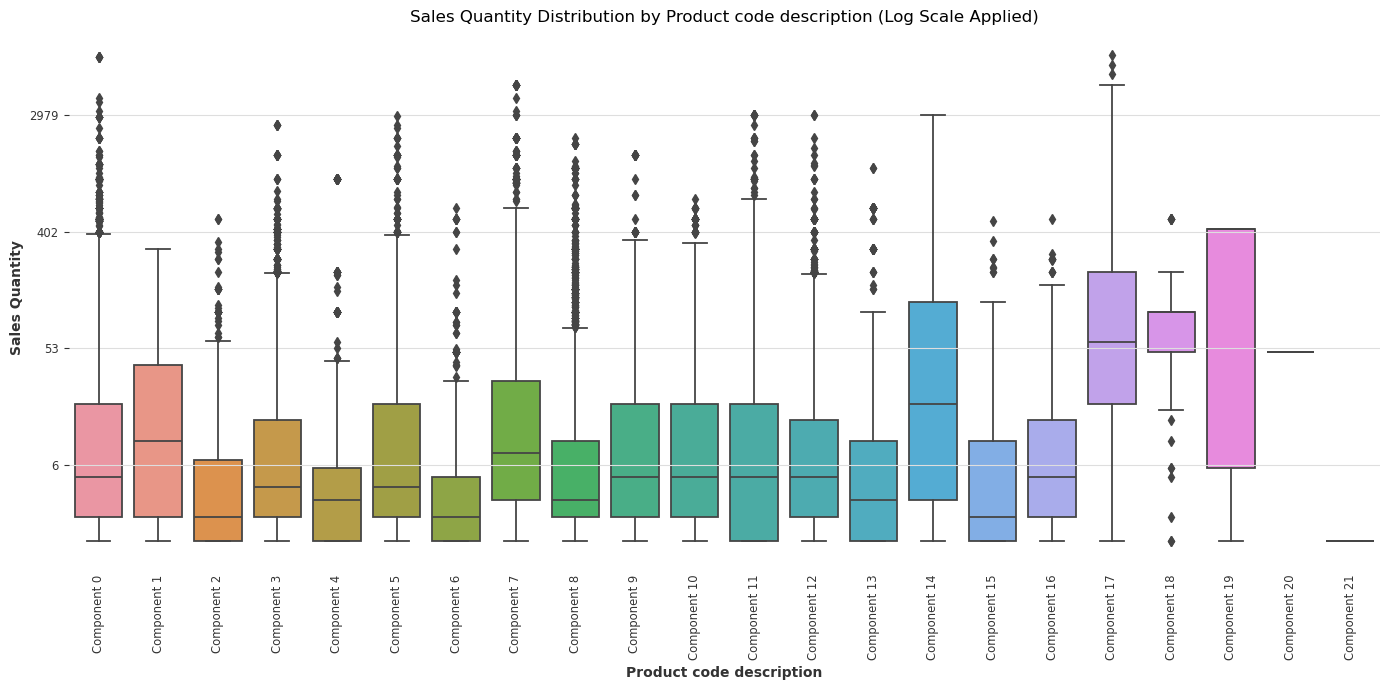

In [20]:
plot_distribution(df, "Product code description", True)

/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/4225235455.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f"{int(np.expm1(tick))}" if tick >= 0 else "0" for tick in ticks])


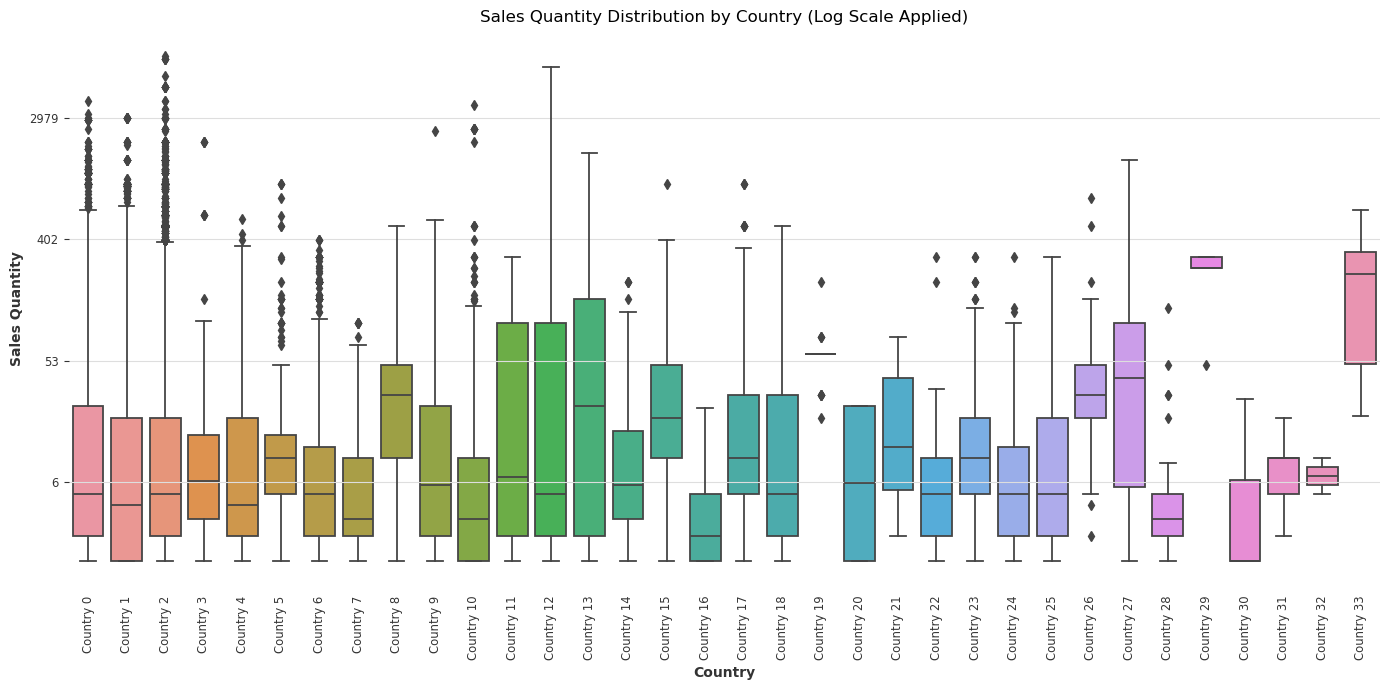

In [21]:
plot_distribution(df, "Country", True)

From those plots, we can see that most of the sales for main categories lay are ussually small amounts. Since the scale is log scaled, we can see the distribution much better

/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/1687574408.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  seasonal_decompose(col_df, model='additive', extrapolate_trend='freq', period=decompose_period).plot().show()
/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/1687574408.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  seasonal_decompose(col_df, model='additive', extrapolate_trend='freq', period=decompose_period).plot().show()


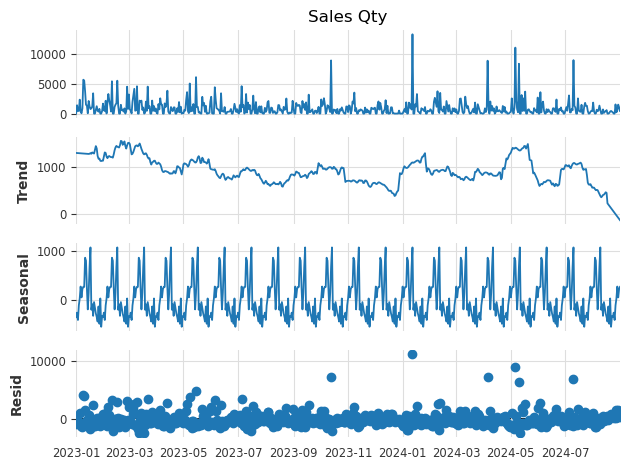

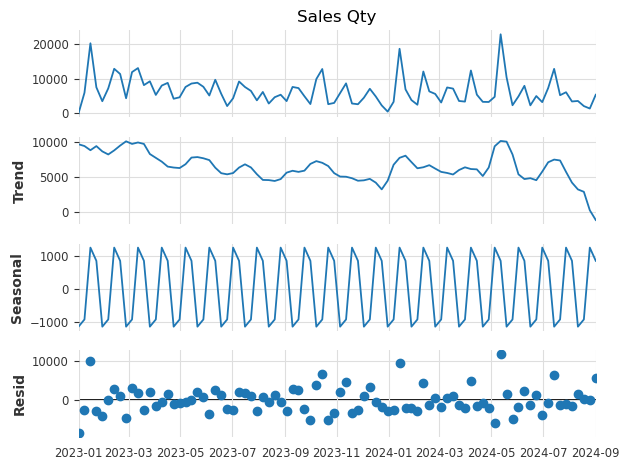

In [22]:
decompose_time_series(df, "Product code description", product_type_cumperc.index.tolist()[0], "D", 30)
decompose_time_series(df, "Product code description", product_type_cumperc.index.tolist()[0], "W", 4)

We can see pretty strong mounthly seasonality, but there are also a lot of residuals.

/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/1687574408.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  seasonal_decompose(col_df, model='additive', extrapolate_trend='freq', period=decompose_period).plot().show()
/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/1687574408.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  seasonal_decompose(col_df, model='additive', extrapolate_trend='freq', period=decompose_period).plot().show()


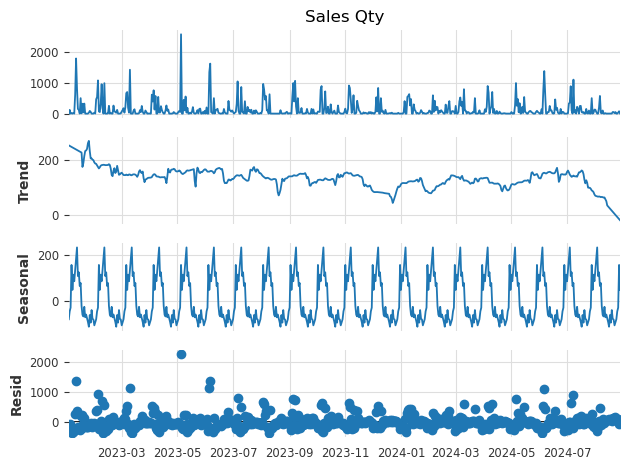

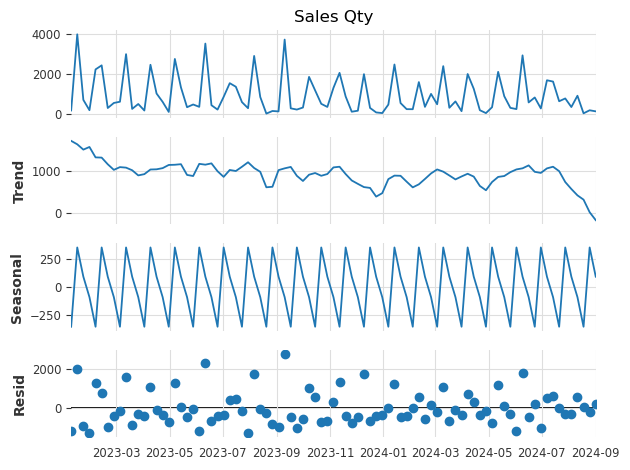

In [23]:
decompose_time_series(df, "Part number", parts_cumperc.index.tolist()[0], "D", 30)
decompose_time_series(df, "Part number", parts_cumperc.index.tolist()[0], "W", 4)

/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/1687574408.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  seasonal_decompose(col_df, model='additive', extrapolate_trend='freq', period=decompose_period).plot().show()
/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/1687574408.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  seasonal_decompose(col_df, model='additive', extrapolate_trend='freq', period=decompose_period).plot().show()


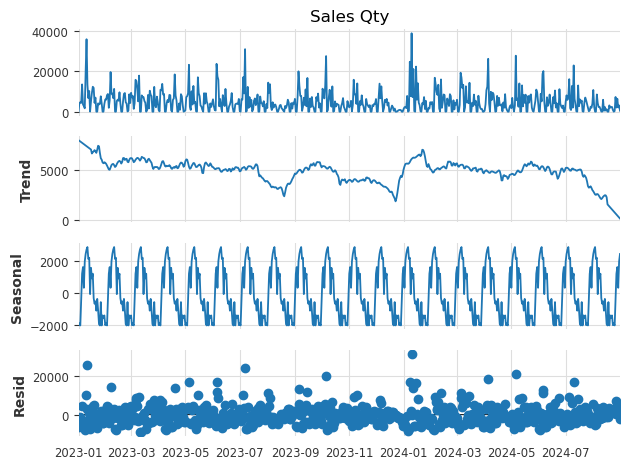

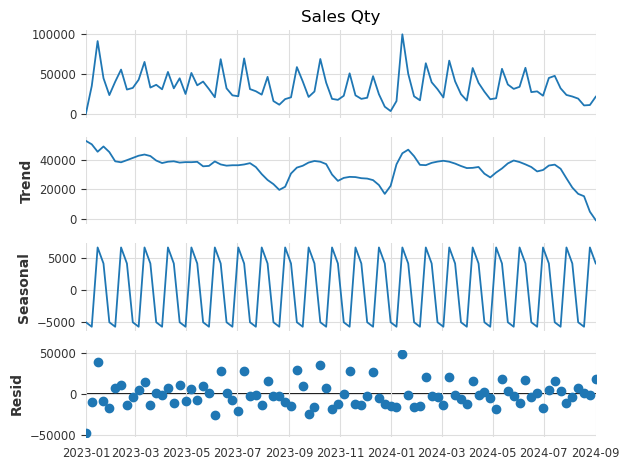

In [24]:
decompose_time_series(df, resample_period="D", decompose_period=30)
decompose_time_series(df, resample_period="W", decompose_period=4)


Component 0
Component 8
Component 3
Component 10
Component 12
Component 7
Component 17
Component 4
Component 5
Component 9


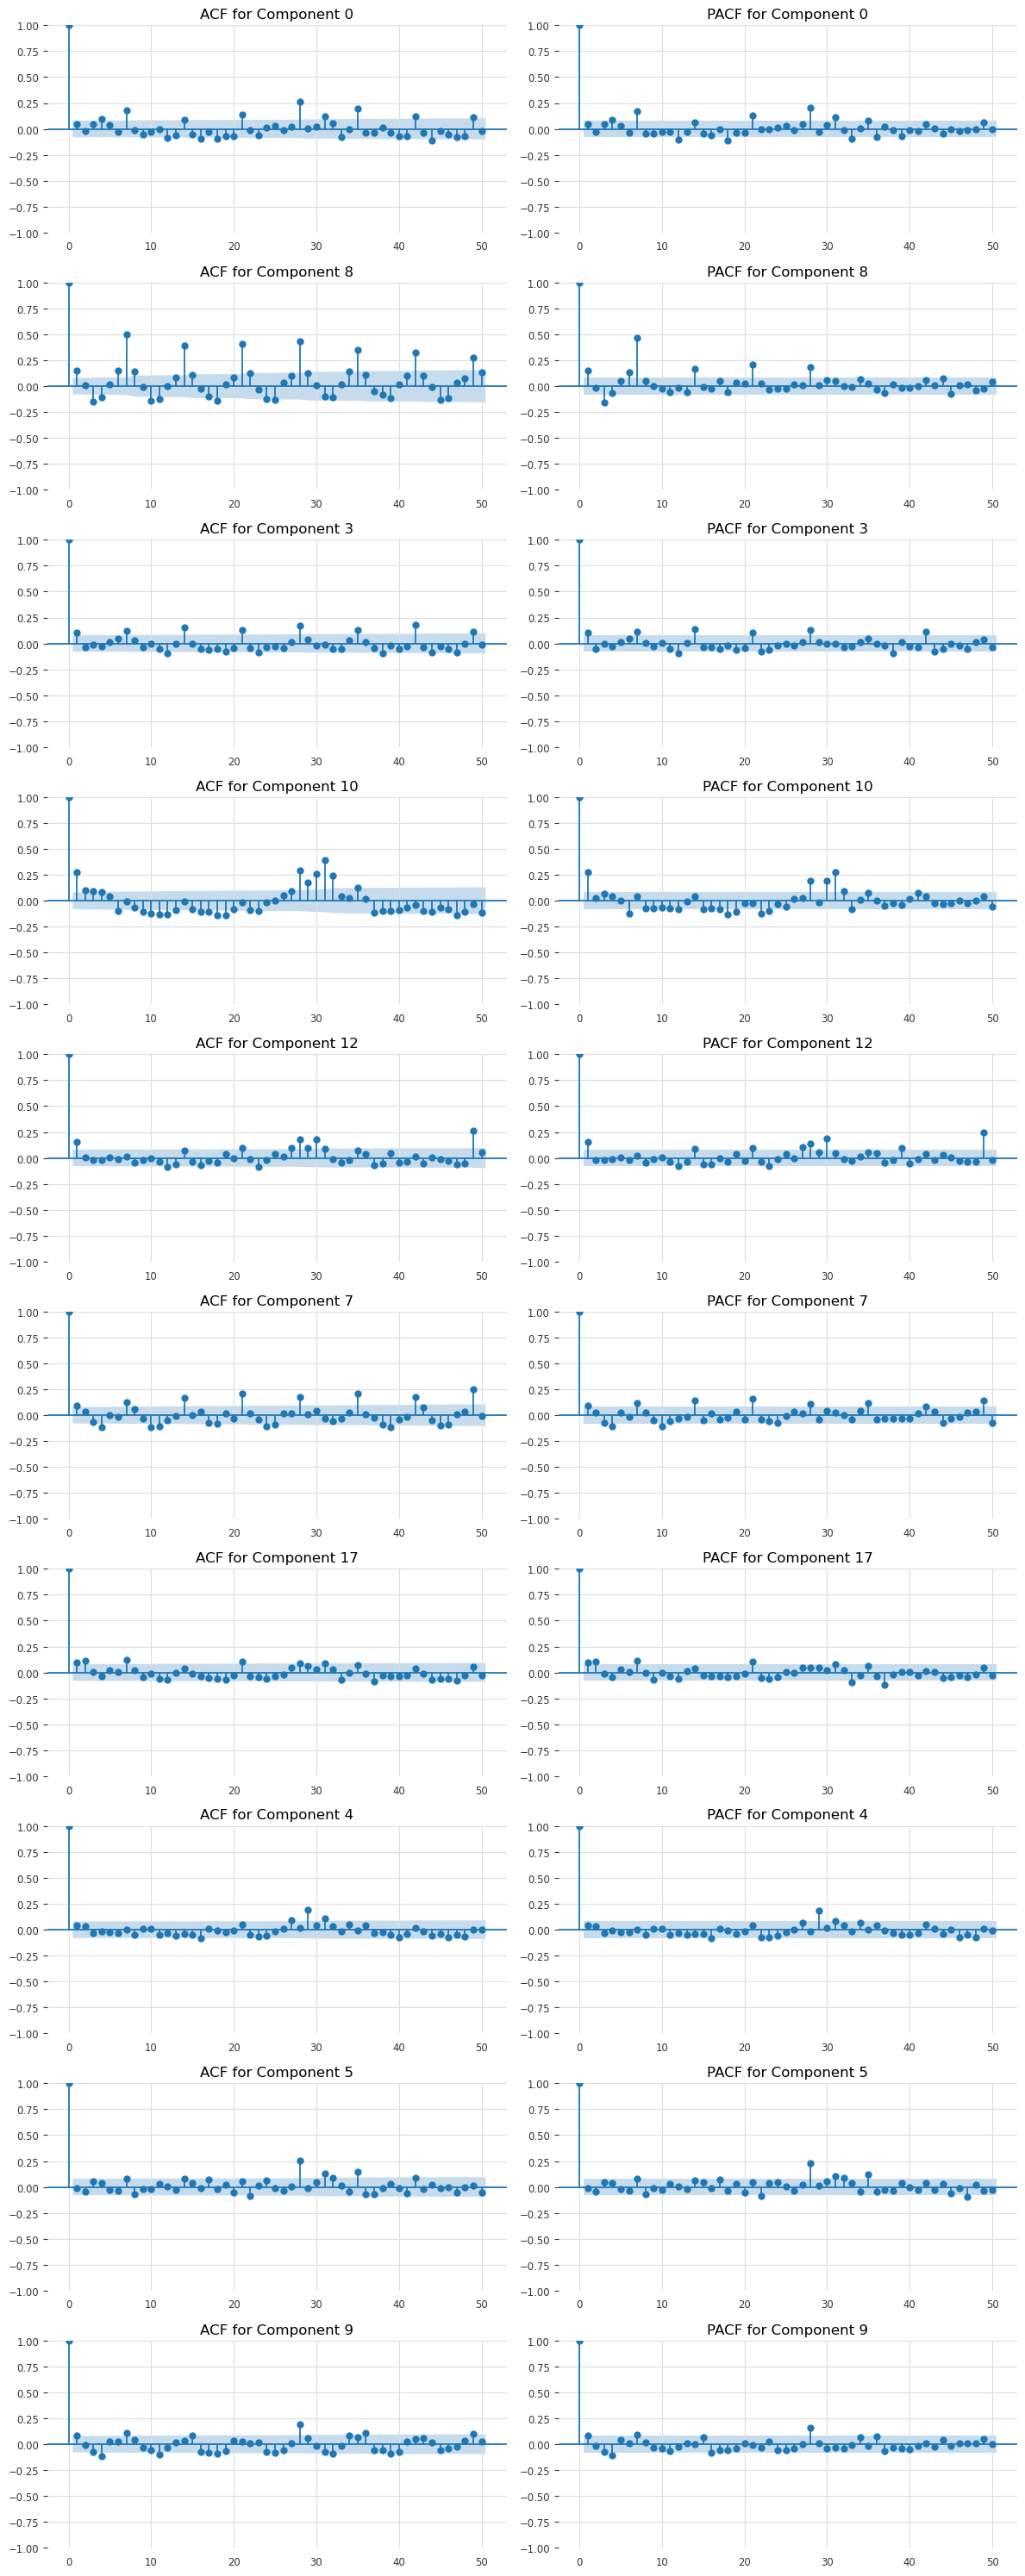

In [25]:
plt.figure(figsize=(12, 30))  # Adjust the height to fit more subplots comfortably

index = 1

for part_name in product_type_cumperc.index.tolist()[:10]:
    print(part_name)
    part_df = df[df["Product code description"] == part_name][["Sales Qty"]].resample("D").sum().fillna(0)
    # Create subplot for ACF
    ax1 = plt.subplot(10, 2, index)  # Use (rows, columns, index)
    plot_acf(part_df["Sales Qty"], ax=ax1, lags=50)
    ax1.set_title(f"ACF for {part_name}")
    index += 1

    # Create subplot for PACF
    ax2 = plt.subplot(10, 2, index)  # Use (rows, columns, index)
    plot_pacf(part_df["Sales Qty"], ax=ax2, lags=50)
    ax2.set_title(f"PACF for {part_name}")
    index += 1

plt.tight_layout()
plt.show()

Based on autocorelation we can see that almost all the data has some degree of monthly autocorelation, but some data has also weekly autocorelation

### Results

We can see strong mounthly seasonality in some data, but this might not be true for all of the data. This trend can be also spoted globally, but for some specific products this does not replicate.

Based on oberved data we can use 2 approaches:
 - Train a model for each Product Code Description (which represent a category)
 - Claster product codes (> 4k) into a few clusters and train a model for each claster. All clasters should share simualar distribution charachteristics.

 In this code we will use both approaches.

## Training for categories

Component 0
There is seasonality of order 4.
There is seasonality of order 7.
There is seasonality of order 11.
There is seasonality of order 14.
There is seasonality of order 21.


/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/2939536016.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part_df["Product code description"] = part_df["Product code description"].astype("str")
/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/2939536016.py:76: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  part_df = part_df[["Product code description", "Sales Qty"]].resample("D").sum().fillna(0)


Lags: 1, MAE: 802.7807598030272
Lags: 2, MAE: 712.2580114573486
Lags: 3, MAE: 767.6853005196438
Lags: 4, MAE: 801.3990532090842
Lags: 5, MAE: 861.4276314747235
Lags: 6, MAE: 713.6375266697781
Lags: 7, MAE: 726.0619652212158
Lags: 8, MAE: 716.6338517646159
Lags: 9, MAE: 576.7558082884008
Lags: 10, MAE: 681.2665735335389
Lags: 11, MAE: 694.3210674494751
Lags: 12, MAE: 663.8941913564836
Lags: 13, MAE: 624.2393814965714
Lags: 14, MAE: 722.9508428184454
Lags: 15, MAE: 782.3555311112365
Lags: 16, MAE: 745.4902960042323
Lags: 17, MAE: 731.1293526360811
Lags: 18, MAE: 709.3815261671119
Lags: 19, MAE: 629.2474817219844
Lags: 20, MAE: 723.0413991114325
Lags: 21, MAE: 672.3402260669992
Lags: 22, MAE: 722.5562513718181
Lags: 23, MAE: 684.9678447987915
Lags: 24, MAE: 691.6315116636024
Lags: 25, MAE: 639.2687264840957
Lags: 26, MAE: 643.7981630779402
Lags: 27, MAE: 606.5773107530164
Lags: 28, MAE: 645.4690379229459
Lags: 29, MAE: 642.8295345808849
Lags: 30, MAE: 697.7110195021984
Best MAE: 576.75580

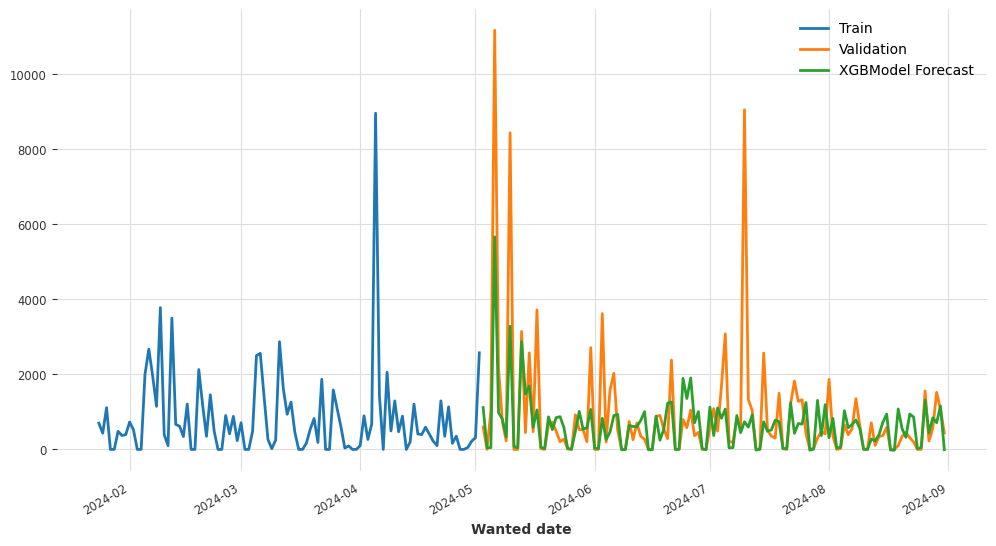

Component 8
There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.


/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/2939536016.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part_df["Product code description"] = part_df["Product code description"].astype("str")
/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/2939536016.py:76: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  part_df = part_df[["Product code description", "Sales Qty"]].resample("D").sum().fillna(0)


Lags: 1, MAE: 533.8915024257673
Lags: 2, MAE: 310.6087124983141
Lags: 3, MAE: 206.27853231489166
Lags: 4, MAE: 237.230171507794
Lags: 5, MAE: 527.602539776401
Lags: 6, MAE: 478.13081820370735
Lags: 7, MAE: 227.05096345314803
Lags: 8, MAE: 181.73569334735555
Lags: 9, MAE: 191.57497342953013
Lags: 10, MAE: 198.92370769547776
Lags: 11, MAE: 176.27018690663428
Lags: 12, MAE: 178.28716256507204
Lags: 13, MAE: 189.40009601395732
Lags: 14, MAE: 190.75872983801955
Lags: 15, MAE: 189.0540817714304
Lags: 16, MAE: 181.68312512744558
Lags: 17, MAE: 186.58743230813792
Lags: 18, MAE: 196.85390402321235
Lags: 19, MAE: 202.8777256776725
Lags: 20, MAE: 193.49665321372757
Lags: 21, MAE: 191.23904660544244
Lags: 22, MAE: 189.289298021935
Lags: 23, MAE: 197.14764353977748
Lags: 24, MAE: 185.58033565274818
Lags: 25, MAE: 221.62161388543765
Lags: 26, MAE: 190.89582440626523
Lags: 27, MAE: 186.4679014963552
Lags: 28, MAE: 199.07200584357435
Lags: 29, MAE: 197.029618631956
Lags: 30, MAE: 172.91351864449987
Be

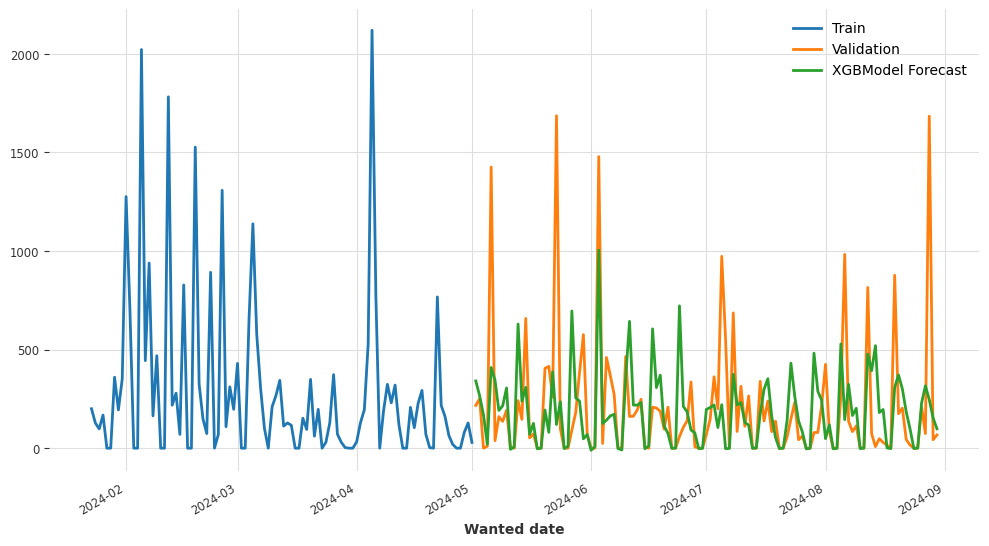

Component 3
There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.


/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/2939536016.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part_df["Product code description"] = part_df["Product code description"].astype("str")
/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/2939536016.py:76: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  part_df = part_df[["Product code description", "Sales Qty"]].resample("D").sum().fillna(0)


Lags: 1, MAE: 369.6831006816596
Lags: 2, MAE: 299.32985287720015
Lags: 3, MAE: 251.11064037212657
Lags: 4, MAE: 330.38291137573145
Lags: 5, MAE: 309.7131527314994
Lags: 6, MAE: 291.90538053965764
Lags: 7, MAE: 294.40554901132407
Lags: 8, MAE: 265.1894465166429
Lags: 9, MAE: 297.85793189667476
Lags: 10, MAE: 273.1920226729852
Lags: 11, MAE: 266.8019430150917
Lags: 12, MAE: 249.2065055573384
Lags: 13, MAE: 302.3780659575108
Lags: 14, MAE: 238.2352421441354
Lags: 15, MAE: 255.8526494170516
Lags: 16, MAE: 232.08652745470528
Lags: 17, MAE: 250.27670858566427
Lags: 18, MAE: 295.2530073771053
Lags: 19, MAE: 249.37148121521184
Lags: 20, MAE: 239.98152189412392
Lags: 21, MAE: 268.8337622858153
Lags: 22, MAE: 227.21696161035416
Lags: 23, MAE: 237.99351906480868
Lags: 24, MAE: 250.11857119037901
Lags: 25, MAE: 248.2417052458387
Lags: 26, MAE: 251.285363571549
Lags: 27, MAE: 242.68742858947925
Lags: 28, MAE: 248.51019989089534
Lags: 29, MAE: 231.50077175576826
Lags: 30, MAE: 227.67050658375763
Bes

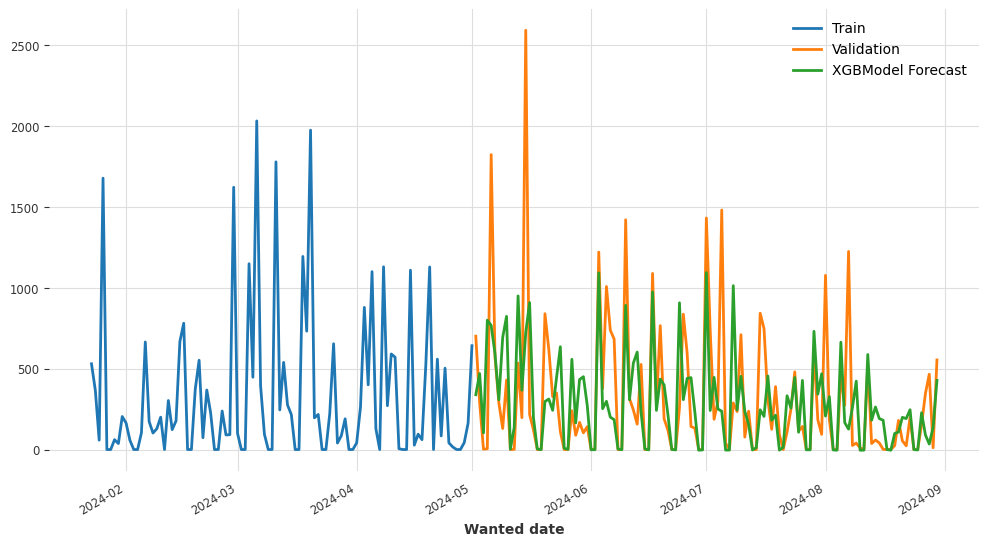

Component 10


/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/2939536016.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part_df["Product code description"] = part_df["Product code description"].astype("str")
/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/2939536016.py:76: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  part_df = part_df[["Product code description", "Sales Qty"]].resample("D").sum().fillna(0)


Lags: 1, MAE: 248.85700800275998
Lags: 2, MAE: 240.6236762547296
Lags: 3, MAE: 327.562787481576
Lags: 4, MAE: 307.4400596081718
Lags: 5, MAE: 254.6423313460074
Lags: 6, MAE: 277.40782075282954
Lags: 7, MAE: 209.26199620838992
Lags: 8, MAE: 219.48141779067103
Lags: 9, MAE: 213.79103524625793
Lags: 10, MAE: 203.89573269639132
Lags: 11, MAE: 192.87243178905536
Lags: 12, MAE: 194.3750527178453
Lags: 13, MAE: 209.55281998549611
Lags: 14, MAE: 215.89743356295853
Lags: 15, MAE: 219.82567624889376
Lags: 16, MAE: 207.96136303824827
Lags: 17, MAE: 241.15663516817014
Lags: 18, MAE: 184.0397141127547
Lags: 19, MAE: 194.90083778323222
Lags: 20, MAE: 182.06766686409958
Lags: 21, MAE: 201.48816109396333
Lags: 22, MAE: 201.41631071503497
Lags: 23, MAE: 210.25988020581647
Lags: 24, MAE: 178.54233808778534
Lags: 25, MAE: 208.10263887651203
Lags: 26, MAE: 231.83523174406082
Lags: 27, MAE: 209.90264352275565
Lags: 28, MAE: 163.2265206794601
Lags: 29, MAE: 170.132385439124
Lags: 30, MAE: 161.60180045553474

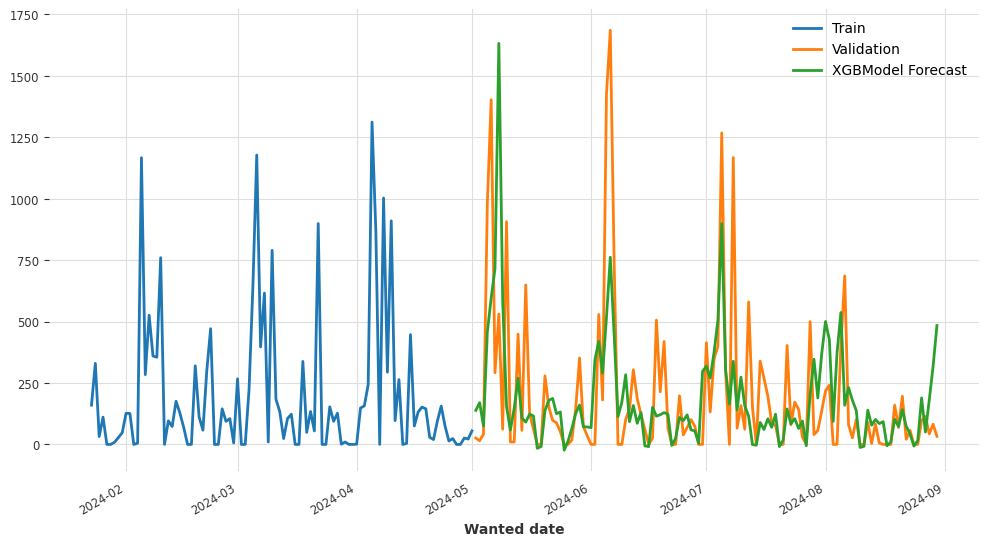

Component 12
There is seasonality of order 5.
There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 19.
There is seasonality of order 21.


/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/2939536016.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part_df["Product code description"] = part_df["Product code description"].astype("str")
/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/2939536016.py:76: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  part_df = part_df[["Product code description", "Sales Qty"]].resample("D").sum().fillna(0)


Lags: 1, MAE: 176.3079189825649
Lags: 2, MAE: 189.3376438226089
Lags: 3, MAE: 195.81442034047498
Lags: 4, MAE: 178.30174539502988
Lags: 5, MAE: 246.85248562816747
Lags: 6, MAE: 361.4501561891934
Lags: 7, MAE: 292.6477604464066
Lags: 8, MAE: 225.14661997581317
Lags: 9, MAE: 155.27838911694928
Lags: 10, MAE: 154.5152290065057
Lags: 11, MAE: 148.76620716767863
Lags: 12, MAE: 168.5264199087935
Lags: 13, MAE: 199.4687827904978
Lags: 14, MAE: 162.86837598438228
Lags: 15, MAE: 191.09901221047255
Lags: 16, MAE: 146.60058038934204
Lags: 17, MAE: 187.76402232912946
Lags: 18, MAE: 134.0213005061854
Lags: 19, MAE: 148.46179670144704
Lags: 20, MAE: 138.73435672634272
Lags: 21, MAE: 138.43891901208843
Lags: 22, MAE: 150.70490075241435
Lags: 23, MAE: 154.35321008617228
Lags: 24, MAE: 148.85314498755557
Lags: 25, MAE: 158.01051029652234
Lags: 26, MAE: 137.13441252215836
Lags: 27, MAE: 127.92049733820286
Lags: 28, MAE: 146.12481188564755
Lags: 29, MAE: 147.73197795290594
Lags: 30, MAE: 144.394459105227

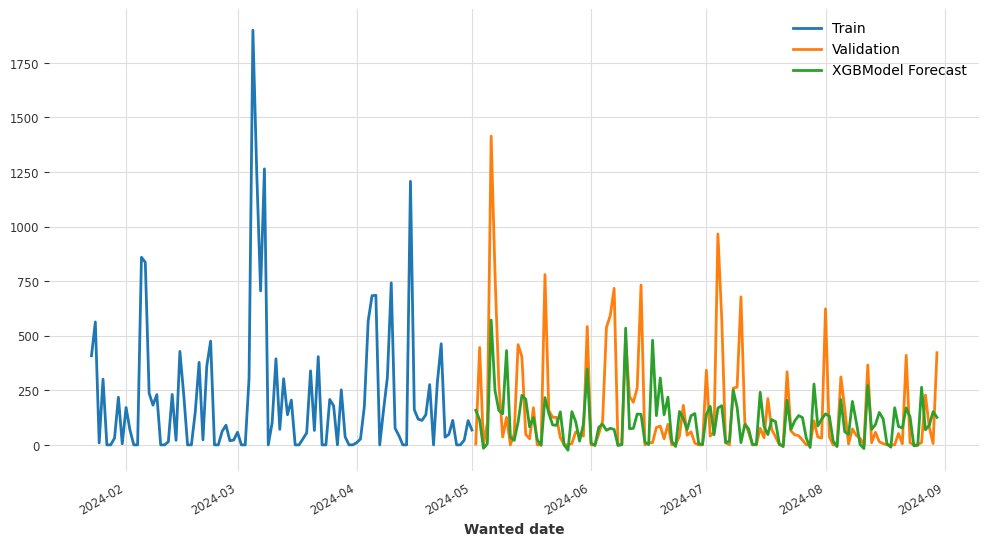

Component 7
There is seasonality of order 5.
There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 16.
There is seasonality of order 19.
There is seasonality of order 21.


/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/2939536016.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part_df["Product code description"] = part_df["Product code description"].astype("str")
/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/2939536016.py:76: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  part_df = part_df[["Product code description", "Sales Qty"]].resample("D").sum().fillna(0)


Lags: 1, MAE: 788.1556133485037
Lags: 2, MAE: 821.3178235620629
Lags: 3, MAE: 740.5705612237789
Lags: 4, MAE: 724.2577607498681
Lags: 5, MAE: 781.1012781375696
Lags: 6, MAE: 690.4020434977595
Lags: 7, MAE: 677.7496373348
Lags: 8, MAE: 681.2810767820059
Lags: 9, MAE: 619.6131168342819
Lags: 10, MAE: 621.9664522044915
Lags: 11, MAE: 664.9138864820653
Lags: 12, MAE: 702.3121829298902
Lags: 13, MAE: 818.6762782088981
Lags: 14, MAE: 748.4777763131236
Lags: 15, MAE: 640.6589859674784
Lags: 16, MAE: 729.7583754515845
Lags: 17, MAE: 790.4519559213937
Lags: 18, MAE: 674.9384667449747
Lags: 19, MAE: 680.2440350508887
Lags: 20, MAE: 645.4949231374362
Lags: 21, MAE: 691.9238213175092
Lags: 22, MAE: 738.6239417941609
Lags: 23, MAE: 743.8056137576576
Lags: 24, MAE: 753.6713983685024
Lags: 25, MAE: 700.7150734485673
Lags: 26, MAE: 718.1450670317184
Lags: 27, MAE: 745.0205935692984
Lags: 28, MAE: 952.9280271746895
Lags: 29, MAE: 847.2521945188853
Lags: 30, MAE: 1235.759390744296
Best MAE: 619.61311683

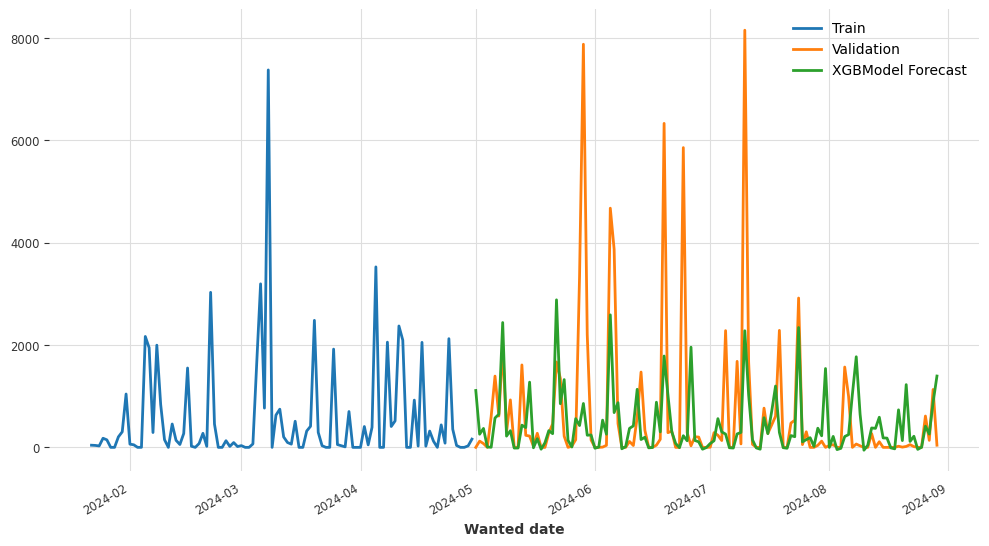

Component 17
There is seasonality of order 2.
There is seasonality of order 5.
There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.


/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/2939536016.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part_df["Product code description"] = part_df["Product code description"].astype("str")
/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/2939536016.py:76: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  part_df = part_df[["Product code description", "Sales Qty"]].resample("D").sum().fillna(0)


Lags: 1, MAE: 1272.4124747514725
Lags: 2, MAE: 913.6834707538287
Lags: 3, MAE: 962.502161326011
Lags: 4, MAE: 1086.5108162730933
Lags: 5, MAE: 881.4276229441166
Lags: 6, MAE: 1125.161644967397
Lags: 7, MAE: 1345.146084833145
Lags: 8, MAE: 1082.674590955178
Lags: 9, MAE: 1077.4245130131642
Lags: 10, MAE: 1065.1677578945955
Lags: 11, MAE: 945.663780900836
Lags: 12, MAE: 1033.9825047262866
Lags: 13, MAE: 860.9704445168376
Lags: 14, MAE: 1200.2080146630606
Lags: 15, MAE: 788.3672517180443
Lags: 16, MAE: 820.3462067703406
Lags: 17, MAE: 824.5311385631561
Lags: 18, MAE: 890.6267225543658
Lags: 19, MAE: 910.0776341756185
Lags: 20, MAE: 816.6302238230904
Lags: 21, MAE: 807.6074095745881
Lags: 22, MAE: 828.1020199889938
Lags: 23, MAE: 874.6690784374873
Lags: 24, MAE: 811.9602381726106
Lags: 25, MAE: 800.6523502478997
Lags: 26, MAE: 797.3405285462737
Lags: 27, MAE: 792.3224528074264
Lags: 28, MAE: 804.294492785136
Lags: 29, MAE: 762.603133196632
Lags: 30, MAE: 841.9803119152784
Best MAE: 762.603

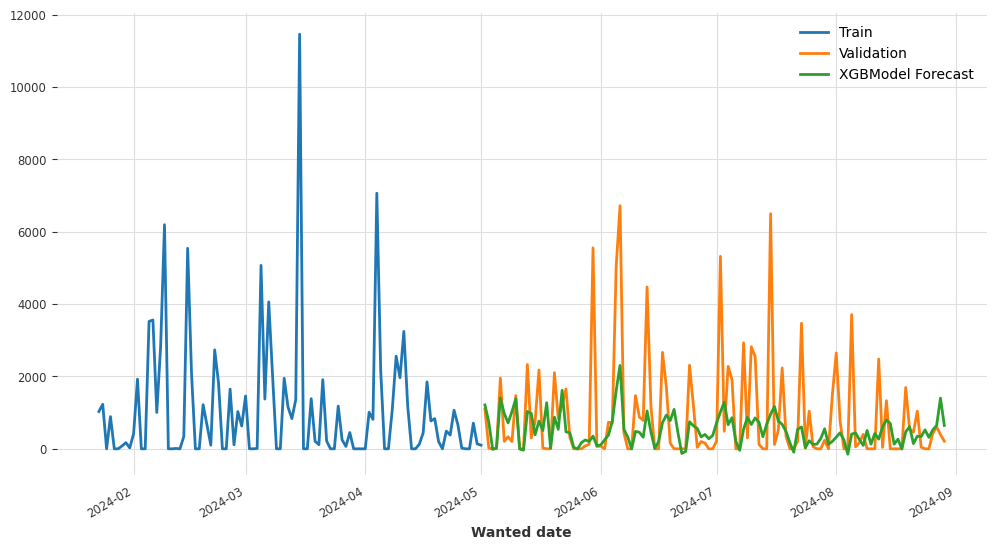

Component 4
There is seasonality of order 7.
There is seasonality of order 10.
There is seasonality of order 17.
There is seasonality of order 21.


/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/2939536016.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part_df["Product code description"] = part_df["Product code description"].astype("str")
/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/2939536016.py:76: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  part_df = part_df[["Product code description", "Sales Qty"]].resample("D").sum().fillna(0)


Lags: 1, MAE: 111.10104549075895
Lags: 2, MAE: 112.0500994870316
Lags: 3, MAE: 128.04611232655108
Lags: 4, MAE: 114.95913456912992
Lags: 5, MAE: 114.65793505237122
Lags: 6, MAE: 109.47910243871598
Lags: 7, MAE: 109.74806287490632
Lags: 8, MAE: 110.75341473482857
Lags: 9, MAE: 103.07589289964723
Lags: 10, MAE: 98.27929587477495
Lags: 11, MAE: 95.24323958515629
Lags: 12, MAE: 97.62340632056402
Lags: 13, MAE: 102.12638006353181
Lags: 14, MAE: 116.56329763563704
Lags: 15, MAE: 155.84551038882458
Lags: 16, MAE: 118.07804388756102
Lags: 17, MAE: 113.69296377330772
Lags: 18, MAE: 111.37896558707041
Lags: 19, MAE: 109.41470288146625
Lags: 20, MAE: 103.7084680562916
Lags: 21, MAE: 113.62102022551554
Lags: 22, MAE: 111.88065677739618
Lags: 23, MAE: 129.09201906990907
Lags: 24, MAE: 109.98680354568585
Lags: 25, MAE: 126.53294960477136
Lags: 26, MAE: 178.67567718189116
Lags: 27, MAE: 112.85006128116088
Lags: 28, MAE: 105.82324417662029
Lags: 29, MAE: 107.82386970033576
Lags: 30, MAE: 108.502006588

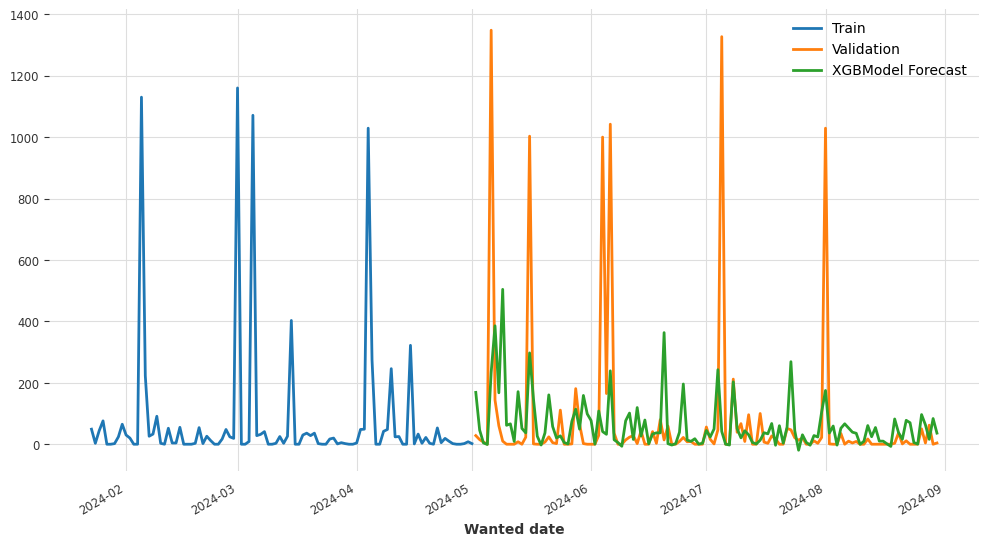

Component 5
There is seasonality of order 3.
There is seasonality of order 7.
There is seasonality of order 11.
There is seasonality of order 14.
There is seasonality of order 17.
There is seasonality of order 19.
There is seasonality of order 21.


/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/2939536016.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part_df["Product code description"] = part_df["Product code description"].astype("str")
/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/2939536016.py:76: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  part_df = part_df[["Product code description", "Sales Qty"]].resample("D").sum().fillna(0)


Lags: 1, MAE: 330.1581199933921
Lags: 2, MAE: 263.81821479531357
Lags: 3, MAE: 263.1480387025628
Lags: 4, MAE: 247.19600732907776
Lags: 5, MAE: 240.21227050763517
Lags: 6, MAE: 254.71830398657104
Lags: 7, MAE: 252.35382858026495
Lags: 8, MAE: 250.72698830277466
Lags: 9, MAE: 239.28545132159326
Lags: 10, MAE: 249.84312883074864
Lags: 11, MAE: 243.88978694736466
Lags: 12, MAE: 239.24974552344932
Lags: 13, MAE: 246.67050980043805
Lags: 14, MAE: 230.8806638635141
Lags: 15, MAE: 237.03019990396402
Lags: 16, MAE: 238.21751262580068
Lags: 17, MAE: 245.99757609436335
Lags: 18, MAE: 246.70470123251607
Lags: 19, MAE: 237.3239908499166
Lags: 20, MAE: 271.50835321868254
Lags: 21, MAE: 264.7130765757285
Lags: 22, MAE: 288.410004749771
Lags: 23, MAE: 253.51122429782203
Lags: 24, MAE: 242.8980285527785
Lags: 25, MAE: 234.08509297028553
Lags: 26, MAE: 252.9387216134505
Lags: 27, MAE: 242.97673833801235
Lags: 28, MAE: 304.03828373896187
Lags: 29, MAE: 316.8916960732996
Lags: 30, MAE: 252.92159322593824

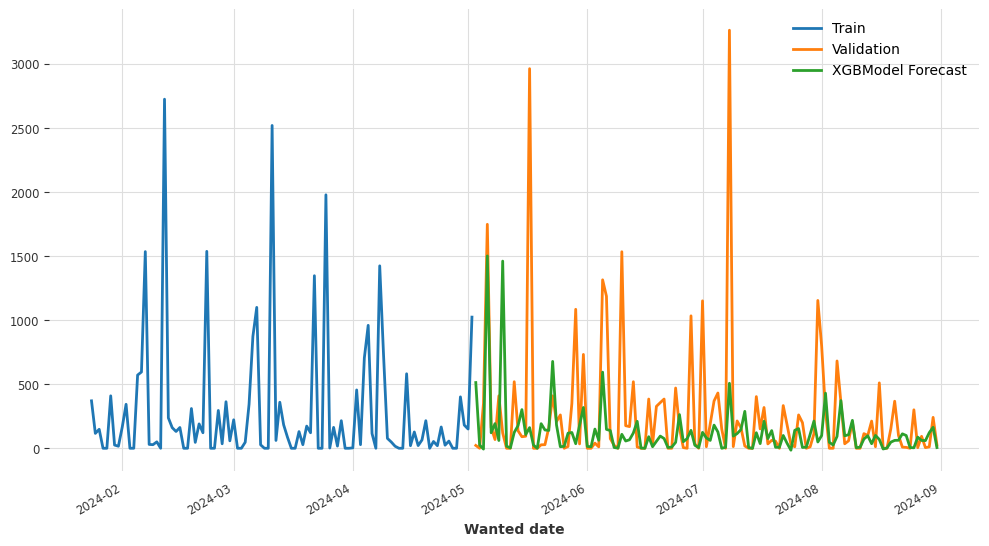

Component 9
There is seasonality of order 5.
There is seasonality of order 7.
There is seasonality of order 15.
There is seasonality of order 20.
There is seasonality of order 23.


/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/2939536016.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part_df["Product code description"] = part_df["Product code description"].astype("str")
/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/2939536016.py:76: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  part_df = part_df[["Product code description", "Sales Qty"]].resample("D").sum().fillna(0)


Lags: 1, MAE: 238.52023147348282
Lags: 2, MAE: 173.755711352037
Lags: 3, MAE: 182.40442325802874
Lags: 4, MAE: 173.72090913589335
Lags: 5, MAE: 141.41355379726275
Lags: 6, MAE: 160.07407965147792
Lags: 7, MAE: 139.69012441553852
Lags: 8, MAE: 156.95605555705896
Lags: 9, MAE: 207.38985175116002
Lags: 10, MAE: 138.55995432142754
Lags: 11, MAE: 158.19013672491366
Lags: 12, MAE: 129.96831972773901
Lags: 13, MAE: 138.31092785217237
Lags: 14, MAE: 209.60884429054136
Lags: 15, MAE: 150.88836320829847
Lags: 16, MAE: 165.1257050530908
Lags: 17, MAE: 145.8320973719709
Lags: 18, MAE: 130.8357268778438
Lags: 19, MAE: 137.03154069490824
Lags: 20, MAE: 135.84771504480977
Lags: 21, MAE: 126.11626733413105
Lags: 22, MAE: 141.31238679477005
Lags: 23, MAE: 133.3537459060057
Lags: 24, MAE: 130.06846154356484
Lags: 25, MAE: 133.61234848392158
Lags: 26, MAE: 139.8775901689448
Lags: 27, MAE: 137.89313911836717
Lags: 28, MAE: 154.36459006553838
Lags: 29, MAE: 138.80066494853043
Lags: 30, MAE: 139.20555295727

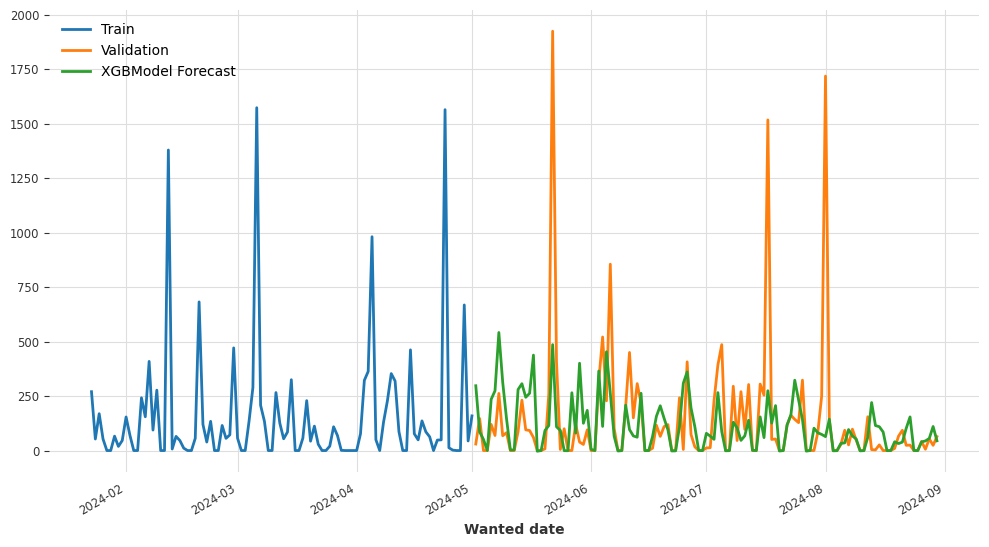

In [26]:
def predict(df):
    # Create the main TimeSeries object, filling missing dates
    series = TimeSeries.from_times_and_values(times=df.index, values=df["Sales Qty"], fill_missing_dates=True, freq="D")

    # Determine the earliest required date for covariates
    max_lag = 50  # Adjust based on your lags settings
    earliest_date_needed = series.start_time() - pd.Timedelta(days=max_lag)

    # Check for seasonality
    for m in range(2, 25):
        is_seasonal, period = check_seasonality(series, m=m, alpha=0.05)
        if is_seasonal:
            print("There is seasonality of order {}.".format(period))

    # Split data into train and validation sets
    split_time = df.iloc[int(len(df) * 0.8)].name
    train_series, val_series = series.split_after(split_time)

    # Determine best lag configuration
    best_eval = float('inf')
    best_lags = 0
    lags_past_covariates = 30

    for lags in range(1, 31):
        model = XGBModel(
            lags=lags,
            lags_past_covariates=lags_past_covariates,
            max_depth=10,
            n_estimators=200,
            n_jobs=-1,
        )

        cov_train = create_covariates(train_series.start_time(), train_series.end_time(), lags_past_covariates)
        cov_val = create_covariates(val_series.start_time(), val_series.end_time(), lags_past_covariates)

        model.fit(
            train_series,
            past_covariates=cov_train
        )
        prediction = model.predict(n=len(val_series), past_covariates=cov_val, show_warnings=False)
        eval = mae(val_series, prediction)
        if eval < best_eval:
            best_eval = eval
            best_lags = lags
        print("Lags: {}, MAE: {}".format(lags, eval))

    # Train the best model on the entire series
    model = XGBModel(
            lags=best_lags,
            lags_past_covariates=lags_past_covariates,
            max_depth=10,
            n_estimators=200,
            n_jobs=-1,
        )
    cov_train = create_covariates(train_series.start_time(), train_series.end_time(), lags_past_covariates)
    cov_val = create_covariates(val_series.start_time(), val_series.end_time(), lags_past_covariates)
    model.fit(train_series, past_covariates=cov_train)
    prediction = model.predict(n=len(val_series), past_covariates=cov_val, show_warnings=False)

    # Output best evaluation metrics
    print("Best MAE: {}\nBest lags: {}".format(best_eval, best_lags))

    # Plotting results
    plt.figure(figsize=(12, 6))
    train_series[-100:].plot(label="Train")
    val_series.plot(label="Validation")
    prediction.plot(label=f"{model.__class__.__name__} Forecast")
    plt.legend()
    plt.show()

# Loop through top parts and run predictions
for part_name in product_type_cumperc[:10].index.tolist():
    print(part_name)
    part_df = df[df["Product code description"] == part_name]
    part_df["Product code description"] = part_df["Product code description"].astype("str")
    part_df = part_df[["Product code description", "Sales Qty"]].resample("D").sum().fillna(0)
    predict(part_df)

## Training for clastering

In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks, peak_widths, peak_prominences
from sklearn.preprocessing import MinMaxScaler

def calculate_sales_features(df):
    # Group data by Part number
    product_groups = df.groupby('Part number')

    feature_list = []

    for product, group in product_groups:
        # Sort by date to make sure data is in time order
        group = group.sort_values(by='Wanted date')
        group.reset_index(inplace=True)

        # Scale the data using Min-Max scaling
        scaler = MinMaxScaler()
        scaled_sales = scaler.fit_transform(group[['Sales Qty']].fillna(0)).flatten()

        # Basic Statistical Features (on scaled data)
        mean_sales = np.mean(scaled_sales)
        std_sales = np.std(scaled_sales)
        median_sales = np.median(scaled_sales)

        # Sales Activity Metrics (original data)
        non_zero_sales_days = (group['Sales Qty'] > 0).mean()
        total_sales_volume = group['Sales Qty'].sum()
        sales_frequency = (group['Sales Qty'] > 0).sum() / len(group['Wanted date'].unique())

        # Trend & Seasonality Features (on original data)
        try:
            if len(group) > 1 and not group['Sales Qty'].isnull().any():
                trend_slope = np.polyfit(range(len(group)), group['Sales Qty'], 1)[0]
            else:
                trend_slope = 0
        except np.linalg.LinAlgError:
            trend_slope = 0

        # Volatility and Consistency (scaled data)
        coefficient_of_variation = std_sales / mean_sales if mean_sales != 0 else 0
        rolling_std = pd.Series(scaled_sales).rolling(window=7).std().mean()

        # Autocorrelation (scaled data)
        autocorr_lag_1 = pd.Series(scaled_sales).autocorr(lag=1) if len(group) > 1 else np.nan
        autocorr_lag_7 = pd.Series(scaled_sales).autocorr(lag=7) if len(group) > 7 else np.nan
        autocorr_lag_30 = pd.Series(scaled_sales).autocorr(lag=30) if len(group) > 30 else np.nan

        # Peak Analysis (scaled data)
        peaks, _ = find_peaks(scaled_sales, height=mean_sales + std_sales)
        num_peaks = len(peaks)
        avg_peak_height = np.mean(scaled_sales[peaks]) if num_peaks > 0 else 0
        peak_frequency = num_peaks / len(group['Wanted date'].unique())

        # Peak Width and Prominence
        if num_peaks > 0:
            peak_widths_result = peak_widths(scaled_sales, peaks, rel_height=0.5)
            avg_peak_width = np.mean(peak_widths_result[0])
            std_peak_width = np.std(peak_widths_result[0])

            prominences = peak_prominences(scaled_sales, peaks)[0]
            avg_peak_prominence = np.mean(prominences)
            std_peak_prominence = np.std(prominences)
        else:
            avg_peak_width = 0
            std_peak_width = 0
            avg_peak_prominence = 0
            std_peak_prominence = 0

        # Compile features for each product
        features = {
            'Part number': product,
            'Mean_Sales': mean_sales,
            'Std_Sales': std_sales,
            'Median_Sales': median_sales,
            'Non_Zero_Sales_Days': non_zero_sales_days,
            'Total_Sales_Volume': total_sales_volume,
            'Sales_Frequency': sales_frequency,
            'Trend_Slope': trend_slope,
            'Coefficient_Of_Variation': coefficient_of_variation,
            'Rolling_Std_7': rolling_std,
            'Autocorr_Lag_1': autocorr_lag_1,
            'Autocorr_Lag_7': autocorr_lag_7,
            'Autocorr_Lag_30': autocorr_lag_30,
            'Num_Peaks': num_peaks,
            'Avg_Peak_Height': avg_peak_height,
            'Peak_Frequency': peak_frequency,
            'Avg_Peak_Width': avg_peak_width,
            'Std_Peak_Width': std_peak_width,
            'Avg_Peak_Prominence': avg_peak_prominence,
            'Std_Peak_Prominence': std_peak_prominence
        }

        feature_list.append(features)

    # Create a new DataFrame with the features
    features_df = pd.DataFrame(feature_list)

    # Handle any potential missing or infinite values
    features_df = features_df.replace([np.inf, -np.inf], np.nan).fillna(0)

    return features_df

# Example usage
feature_df = calculate_sales_features(df)

In [28]:
feature_df.sample(50)

Part number  Mean_Sales  Std_Sales  Median_Sales  Non_Zero_Sales_Days  \
3319   Part 3986    0.000000   0.000000      0.000000                  1.0   
3360   Part 4021    0.000000   0.000000      0.000000                  1.0   
714    Part 1640    0.000000   0.000000      0.000000                  1.0   
3806    Part 756    0.353535   0.392844      0.151515                  1.0   
1451   Part 2303    0.376093   0.351430      0.387755                  1.0   
3207   Part 3885    0.000000   0.000000      0.000000                  1.0   
3774    Part 727    0.467672   0.305262      0.498998                  1.0   
2770   Part 3491    0.000000   0.000000      0.000000                  1.0   
2465   Part 3216    0.000000   0.000000      0.000000                  1.0   
1442   Part 2296    0.331522   0.285882      0.304348                  1.0   
1303   Part 2170    0.000000   0.000000      0.000000                  1.0   
4049    Part 975    0.201389   0.333839      0.000000                  1.0   
2555   Part 3298    0.500000   0.500000      0.500000                  1.0   
3698    Part 659    0.158730   0.229539      0.066667                  1.0   
721    Part 1647    0.239130   0.272691      0.142857                  1.0   
3639    Part 605    0.234818   0.310080      0.105263                  1.0   
3409   Part 4066    0.000000   0.000000      0.000000                  1.0   
442    Part 1396    0.586420   0.340571      0.444444                  1.0   
1384   Part 2243    0.666667   0.471405      1.000000                  1.0   
567    Part 1508    0.094694   0.268141      0.000000                  1.0   
528    Part 1473    0.857143   0.349927      1.000000                  1.0   
3221   Part 3898    0.333333   0.471405      0.000000                  1.0   
2087   Part 2877    0.500000   0.500000      0.500000                  1.0   
3236   Part 3910    0.000000   0.000000      0.000000                  1.0   
2073   Part 2864    0.370370   0.447520      0.111111                  1.0   
1254   Part 2126    0.500000   0.500000      0.500000                  1.0   
1622   Part 2458    0.000000   0.000000      0.000000                  1.0   
3943     Part 88    0.333333   0.343592      0.250000                  1.0   
111    Part 1098    0.193966   0.288214      0.086207                  1.0   
2065   Part 2857    0.000000   0.000000      0.000000                  1.0   
1596   Part 2434    0.333333   0.471405      0.000000                  1.0   
3272   Part 3943    0.000000   0.000000      0.000000                  1.0   
2809   Part 3526    0.000000   0.000000      0.000000                  1.0   
3073   Part 3764    0.000000   0.000000      0.000000                  1.0   
1584   Part 2423    0.363636   0.451505      0.090909                  1.0   
2441   Part 3195    0.000000   0.000000      0.000000                  1.0   
3348   Part 4010    0.000000   0.000000      0.000000                  1.0   
3359   Part 4020    0.000000   0.000000      0.000000                  1.0   
1556   Part 2399    0.500000   0.500000      0.500000                  1.0   
799    Part 1717    0.000000   0.000000      0.000000                  1.0   
1085   Part 1975    0.300000   0.341565      0.200000                  1.0   
379    Part 1339    0.169960   0.300083      0.000000                  1.0   
2661   Part 3393    0.000000   0.000000      0.000000                  1.0   
2559   Part 3300    0.000000   0.000000      0.000000                  1.0   
413     Part 137    0.110225   0.251386      0.010050                  1.0   
899    Part 1807    0.333333   0.408248      0.166667                  1.0   
2625   Part 3360    0.000000   0.000000      0.000000                  1.0   
2050   Part 2843    0.388889   0.355729      0.333333                  1.0   
392    Part 1350    0.428571   0.494872      0.000000                  1.0   
1586   Part 2425    0.354762   0.311641      0.450000                  1.0   

      Total_Sales_Volume  

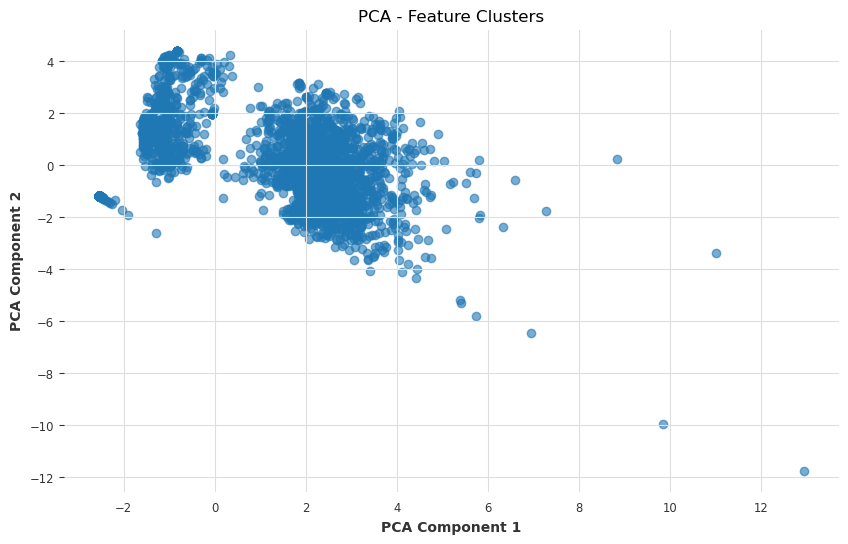

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def plot_pca(df, n_components=2):
    features = df.drop(columns=['Part number'])  # Drop identifier columns
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(scaled_features)

    plt.figure(figsize=(10, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('PCA - Feature Clusters')
    plt.show()

plot_pca(feature_df)

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def plot_pca_clusters(df, n_components=2):
    # Ensure the DataFrame has a 'Cluster' column for color-coding
    if 'Cluster' not in df.columns:
        raise ValueError("The DataFrame must contain a 'Cluster' column for visualization.")

    # Separate features from the cluster labels
    features = df.drop(columns=['Part number', 'Cluster'])
    cluster_labels = df['Cluster']

    # Scale the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(scaled_features)

    # Create a DataFrame for plotting
    pca_df = pd.DataFrame({
        'PCA1': pca_result[:, 0],
        'PCA2': pca_result[:, 1],
        'Cluster': cluster_labels
    })

    # Plot with Seaborn
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', palette='Set2', data=pca_df, alpha=0.7)
    plt.title('PCA - Feature Clusters')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_pca_clusters(clustered_df_kmeans)

In [31]:
# 1. t-SNE for Visualizing Clusters
def plot_tsne_clusters(df, n_components=2, perplexity=30, n_iter=1000):
    if 'Cluster' not in df.columns:
        raise ValueError("The DataFrame must contain a 'Cluster' column for visualization.")

    # Separate features and cluster labels
    features = df.drop(columns=['Part number', 'Cluster'])
    cluster_labels = df['Cluster']

    # Scale the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Perform t-SNE
    tsne = TSNE(n_components=n_components, perplexity=perplexity, n_iter=n_iter, random_state=42)
    tsne_result = tsne.fit_transform(scaled_features)

    # Create a DataFrame for plotting
    tsne_df = pd.DataFrame({
        't-SNE1': tsne_result[:, 0],
        't-SNE2': tsne_result[:, 1],
        'Cluster': cluster_labels
    })

    # Plot with Seaborn
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Cluster', palette='Set2', data=tsne_df, alpha=0.7)
    plt.title('t-SNE - Feature Clusters')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


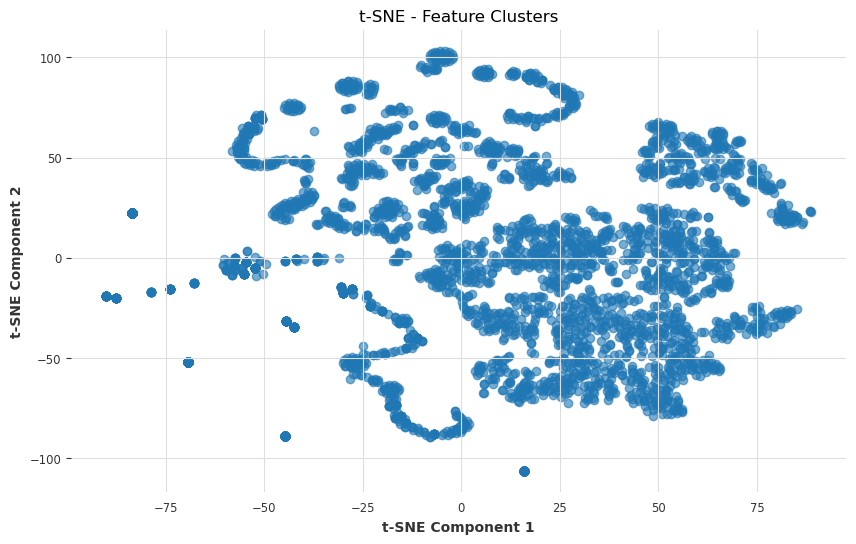

In [32]:
from sklearn.manifold import TSNE

# 1. t-SNE for Visualizing Clusters
def plot_tsne(df, n_components=2, perplexity=30, n_iter=1000):
    features = df.drop(columns=['Part number'])  # Drop identifier columns
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    tsne = TSNE(n_components=n_components, perplexity=perplexity, n_iter=n_iter, random_state=42)
    tsne_result = tsne.fit_transform(scaled_features)

    plt.figure(figsize=(10, 6))
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.6)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title('t-SNE - Feature Clusters')
    plt.show()


plot_tsne(feature_df)

Silhouette Score for K-Means: 0.45


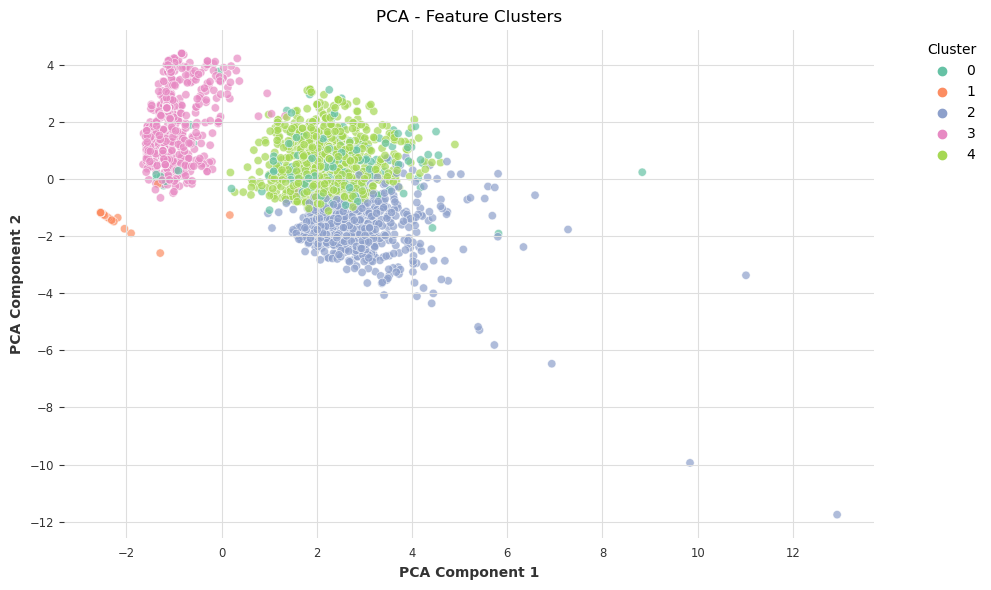

/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


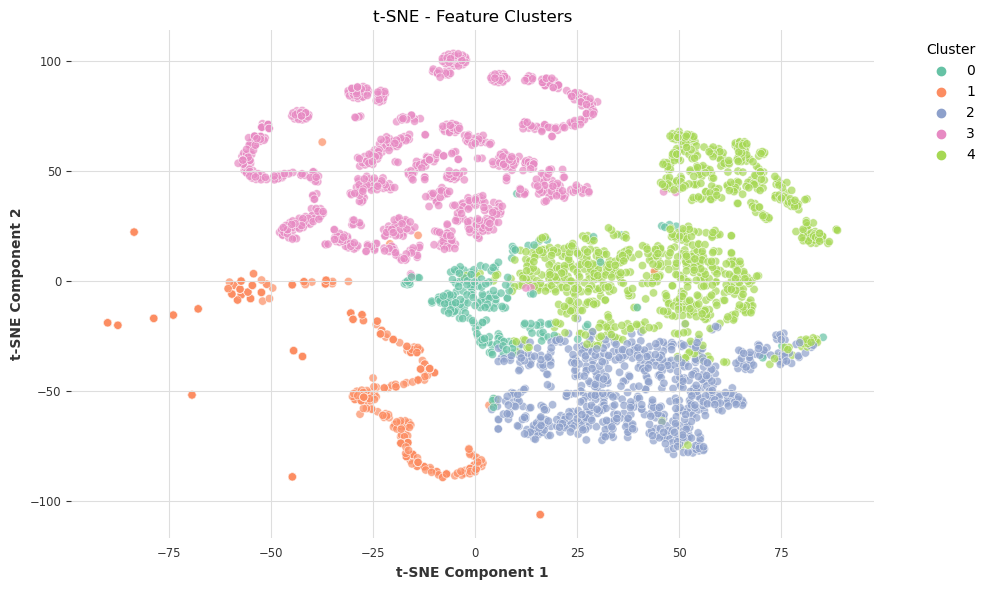

Number of clusters found by DBSCAN: 23


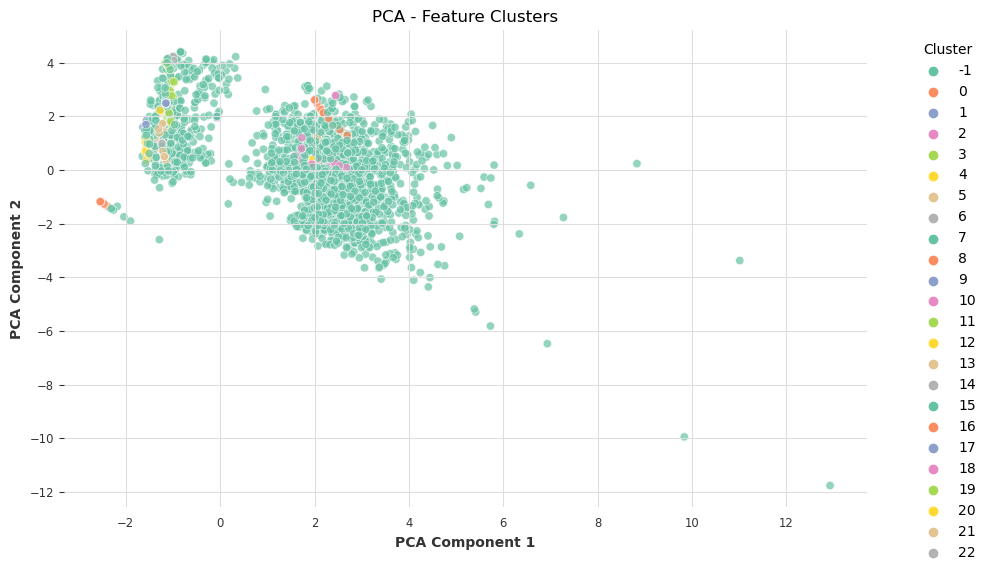

/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


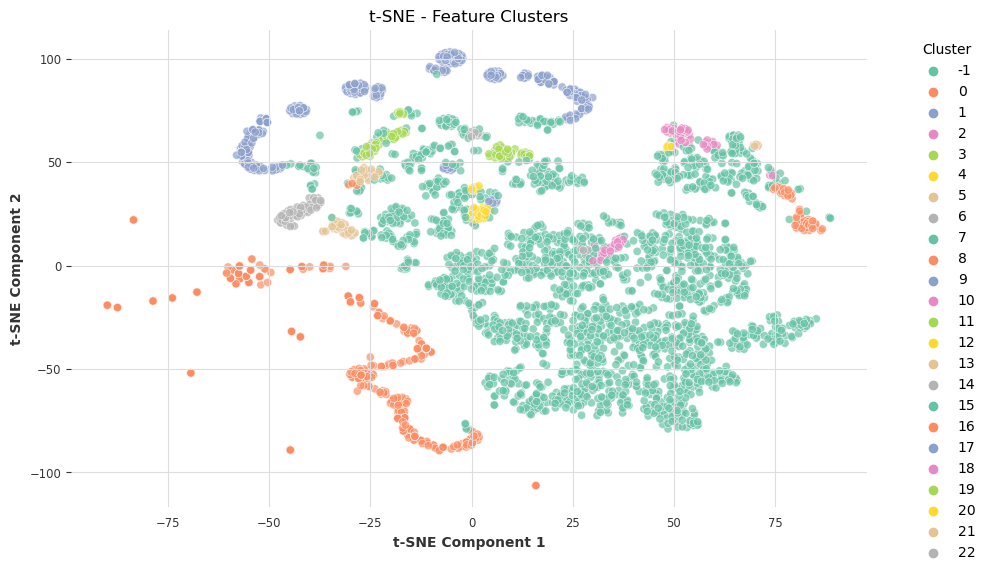

In [33]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Function to Standardize Features
def standardize_features(df):
    features = df.drop(columns=['Part number'])
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    return scaled_features

# 2. K-Means Clustering
def perform_kmeans_clustering(df, n_clusters=5):
    scaled_features = standardize_features(df)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)

    # Add cluster labels to the DataFrame
    df['Cluster'] = cluster_labels

    # Evaluate the clustering with Silhouette Score
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    print(f'Silhouette Score for K-Means: {silhouette_avg:.2f}')

    return df, kmeans

# 3. DBSCAN Clustering
def perform_dbscan_clustering(df, eps=0.5, min_samples=5):
    scaled_features = standardize_features(df)
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(scaled_features)

    # Add cluster labels to the DataFrame
    df['Cluster'] = cluster_labels

    # Evaluate clustering by counting unique clusters (DBSCAN assigns -1 to outliers)
    unique_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    print(f'Number of clusters found by DBSCAN: {unique_clusters}')

    return df, dbscan

# 4. Visualize Clusters using PCA
def visualize_clusters(df):
    plot_pca_clusters(df)  # Use the PCA visualization function from previous example
    plot_tsne_clusters(df)  # Use the t-SNE visualization function from previous example

# Example usage:
# For K-Means
clustered_df_kmeans, kmeans_model = perform_kmeans_clustering(feature_df, n_clusters=5)
visualize_clusters(clustered_df_kmeans)

# For DBSCAN
clustered_df_dbscan, dbscan_model = perform_dbscan_clustering(feature_df, eps=0.5, min_samples=5)
visualize_clusters(clustered_df_dbscan)

In [34]:
clustered_df_kmeans, kmeans_model = perform_kmeans_clustering(feature_df, n_clusters=8)

clustered_df_kmeans["Cluster"].value_counts()

Silhouette Score for K-Means: 0.43


1    1338
3     955
2     577
7     475
6     333
4     200
0     182
5      16
Name: Cluster, dtype: int64

In [35]:
# Drop the columns you don't want to include in the aggregation
columns_to_drop = [
    "Mean_Sales", "Std_Sales", "Median_Sales", "Non_Zero_Sales_Days",
    "Total_Sales_Volume", "Sales_Frequency", "Trend_Slope", "Coefficient_Of_Variation",
    "Rolling_Std_7", "Autocorr_Lag_1", "Autocorr_Lag_7", "Autocorr_Lag_30",
    "Num_Peaks", "Avg_Peak_Height", "Peak_Frequency", "Avg_Peak_Width",
    "Std_Peak_Width", "Avg_Peak_Prominence", "Std_Peak_Prominence"
]

# Drop those columns from the DataFrame
cleaned_df = clustered_df_kmeans.drop(columns=columns_to_drop)

# Now you can group and aggregate
clustered_data = cleaned_df.groupby("Cluster").agg({
    "Part number": lambda x: ",".join(x)
})

clustered_data["Part number"] = clustered_data["Part number"].transform(lambda x: x.split(","))

clustered_data

Part number
Cluster                                                   
0        [Part 1007, Part 1014, Part 1029, Part 103, Pa...
1        [Part 0, Part 1000, Part 1002, Part 1015, Part...
2        [Part 10, Part 1003, Part 1004, Part 1005, Par...
3        [Part 1012, Part 1020, Part 1023, Part 1039, P...
4        [Part 1031, Part 1051, Part 1093, Part 1106, P...
5        [Part 1006, Part 16, Part 173, Part 18, Part 1...
6        [Part 1, Part 100, Part 1001, Part 1010, Part ...
7        [Part 1008, Part 1013, Part 1019, Part 1021, P...

In [36]:
clusters_list = []

for cluster in clustered_data["Part number"]:
    clusters_list.append(df[df["Part number"].isin(cluster)])

In [37]:
clusters_list[0]

Country Part number Part Description  Sales Qty  \
Wanted date                                                       
2023-01-02    Country 1      Part 4        Product 4          2   
2023-01-02    Country 0     Part 69       Product 67          5   
2023-01-02    Country 0     Part 80       Product 78          1   
2023-01-03    Country 0    Part 103       Product 10          3   
2023-01-03    Country 0    Part 108       Product 24          3   
...                 ...         ...              ...        ...   
2024-08-29   Country 12   Part 1247     Product 1052          3   
2024-08-29    Country 1   Part 1620      Product 301          2   
2024-08-30    Country 1    Part 628      Product 438          4   
2024-08-30    Country 6   Part 1014      Product 864          2   
2024-08-30    Country 9   Part 2798     Product 2271         10   

            Customer market Product code description  
Wanted date                                           
2023-01-02       Industry 3              Component 4  
2023-01-02       Industry 0             Component 13  
2023-01-02       Industry 3              Component 3  
2023-01-03       Industry 3              Component 8  
2023-01-03       Industry 3              Component 8  
...                     ...                      ...  
2024-08-29       Industry 3             Component 16  
2024-08-29       Industry 3             Component 10  
2024-08-30       Industry 3             Component 12  
2024-08-30       Industry 3              Component 0  
2024-08-30       Industry 3              Component 0  

[2753 rows x 6 columns]

There is seasonality of order 3.
There is seasonality of order 7.
There is seasonality of order 10.
There is seasonality of order 14.
There is seasonality of order 18.
There is seasonality of order 21.


/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/299424543.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df["Product code description"] = cluster_df["Product code description"].astype("str")
/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/299424543.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_df = cluster_df[["Product code description", "Sales Qty"]].resample("D").sum().fillna(0)


Lags: 1, MAE: 295.1021589501472
Lags: 2, MAE: 290.65234172750604
Lags: 3, MAE: 291.7666114834715
Lags: 4, MAE: 272.5736504911391
Lags: 5, MAE: 296.7250095231474
Lags: 6, MAE: 257.46698997631546
Lags: 7, MAE: 261.89197954658636
Lags: 8, MAE: 252.25384225523916
Lags: 9, MAE: 239.6802746944191
Lags: 10, MAE: 234.35273638540062
Lags: 11, MAE: 251.69845595450934
Lags: 12, MAE: 227.7330565925472
Lags: 13, MAE: 250.7693051025887
Lags: 14, MAE: 268.9003081036008
Lags: 15, MAE: 277.76728309284556
Lags: 16, MAE: 273.7589583308243
Lags: 17, MAE: 210.93112181262538
Lags: 18, MAE: 221.5593929765207
Lags: 19, MAE: 246.94686360804997
Lags: 20, MAE: 239.68721212455156
Lags: 21, MAE: 268.0068073888456
Lags: 22, MAE: 224.94942560077698
Lags: 23, MAE: 231.55107151255135
Lags: 24, MAE: 224.00142223049295
Lags: 25, MAE: 241.0650533071896
Lags: 26, MAE: 248.86066229678383
Lags: 27, MAE: 263.9123330284988
Lags: 28, MAE: 252.7857472814681
Lags: 29, MAE: 270.82615396257273
Lags: 30, MAE: 273.6582420037305
Best

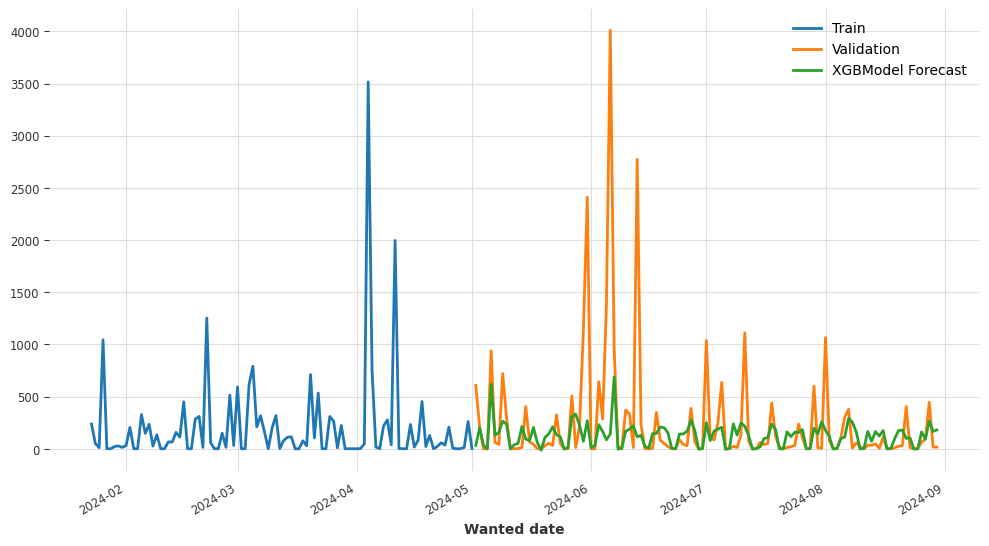

There is seasonality of order 5.
There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 19.
There is seasonality of order 21.


/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/299424543.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df["Product code description"] = cluster_df["Product code description"].astype("str")
/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/299424543.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_df = cluster_df[["Product code description", "Sales Qty"]].resample("D").sum().fillna(0)


Lags: 1, MAE: 273.63118288733745
Lags: 2, MAE: 264.48007584332436
Lags: 3, MAE: 264.99783049782445
Lags: 4, MAE: 264.29615937579763
Lags: 5, MAE: 255.93743448624434
Lags: 6, MAE: 243.75797191877996
Lags: 7, MAE: 230.22902852837151
Lags: 8, MAE: 216.85608014624472
Lags: 9, MAE: 290.25413668112566
Lags: 10, MAE: 227.16238736490573
Lags: 11, MAE: 242.86060829694605
Lags: 12, MAE: 234.1345981398274
Lags: 13, MAE: 267.4036650272136
Lags: 14, MAE: 269.60403574990835
Lags: 15, MAE: 279.25942996292076
Lags: 16, MAE: 282.8377564644272
Lags: 17, MAE: 239.61144086773976
Lags: 18, MAE: 237.2408432586134
Lags: 19, MAE: 297.39721433091756
Lags: 20, MAE: 332.40938600737695
Lags: 21, MAE: 334.58680199628526
Lags: 22, MAE: 242.0459682978382
Lags: 23, MAE: 275.90120350132304
Lags: 24, MAE: 262.2957723283571
Lags: 25, MAE: 291.3738498626169
Lags: 26, MAE: 264.8829981827539
Lags: 27, MAE: 241.60615099261491
Lags: 28, MAE: 298.4183240061826
Lags: 29, MAE: 237.42667525686508
Lags: 30, MAE: 220.1577250802319

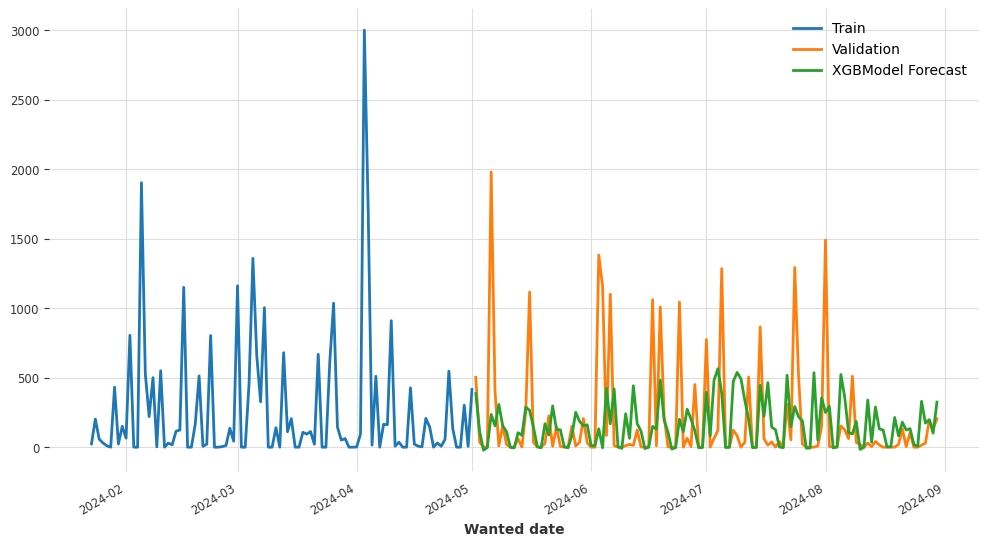

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.


/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/299424543.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df["Product code description"] = cluster_df["Product code description"].astype("str")
/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/299424543.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_df = cluster_df[["Product code description", "Sales Qty"]].resample("D").sum().fillna(0)


Lags: 1, MAE: 797.8811572228582
Lags: 2, MAE: 735.8130469046348
Lags: 3, MAE: 822.3377917029641
Lags: 4, MAE: 956.2071576354917
Lags: 5, MAE: 942.4425513271458
Lags: 6, MAE: 812.7500832706444
Lags: 7, MAE: 882.3992882245336
Lags: 8, MAE: 861.044191951594
Lags: 9, MAE: 827.3508855823643
Lags: 10, MAE: 902.6127033073548
Lags: 11, MAE: 775.5947562128551
Lags: 12, MAE: 822.902527269253
Lags: 13, MAE: 786.922372670213
Lags: 14, MAE: 804.1246033273945
Lags: 15, MAE: 860.6241161094224
Lags: 16, MAE: 790.2731129522319
Lags: 17, MAE: 828.2130227714531
Lags: 18, MAE: 779.2924890468928
Lags: 19, MAE: 827.5154018522786
Lags: 20, MAE: 867.4536529443235
Lags: 21, MAE: 784.3539177322191
Lags: 22, MAE: 755.0321866880856
Lags: 23, MAE: 812.165923065021
Lags: 24, MAE: 805.505428893507
Lags: 25, MAE: 863.7993038653835
Lags: 26, MAE: 806.8355951508707
Lags: 27, MAE: 839.023737563082
Lags: 28, MAE: 742.7392749242515
Lags: 29, MAE: 810.2202418047534
Lags: 30, MAE: 818.3408645179646
Best MAE: 735.81304690463

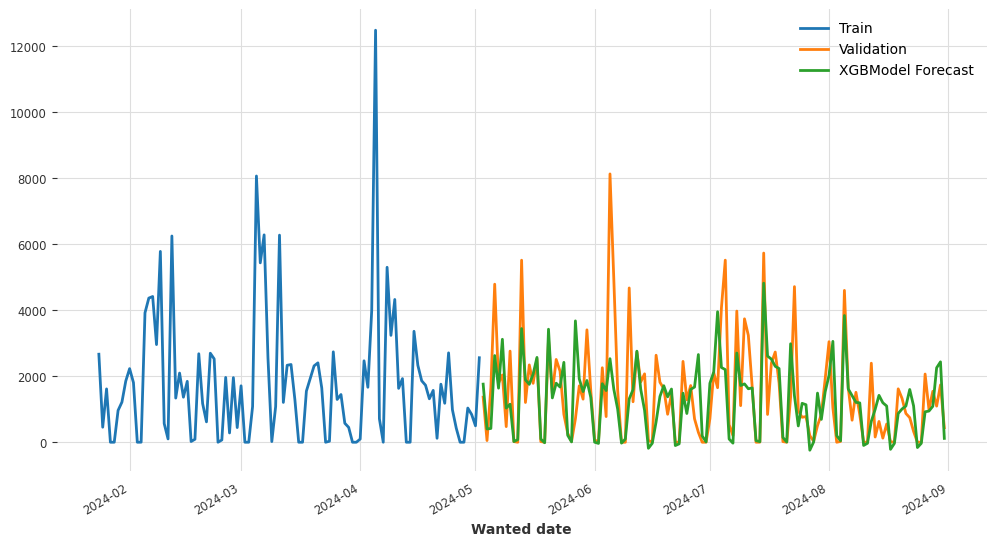

There is seasonality of order 3.
There is seasonality of order 7.
There is seasonality of order 9.
There is seasonality of order 14.
There is seasonality of order 21.


/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/299424543.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df["Product code description"] = cluster_df["Product code description"].astype("str")
/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/299424543.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_df = cluster_df[["Product code description", "Sales Qty"]].resample("D").sum().fillna(0)


Lags: 1, MAE: 731.0782224120926
Lags: 2, MAE: 1054.6022742944808
Lags: 3, MAE: 516.0136029552822
Lags: 4, MAE: 756.4734875072132
Lags: 5, MAE: 665.046695255051
Lags: 6, MAE: 786.4303947342329
Lags: 7, MAE: 624.3965578310746
Lags: 8, MAE: 610.0234488120749
Lags: 9, MAE: 619.1065666498231
Lags: 10, MAE: 681.2974246375817
Lags: 11, MAE: 606.621920645237
Lags: 12, MAE: 631.8529709213036
Lags: 13, MAE: 593.0770108286014
Lags: 14, MAE: 552.4575485588351
Lags: 15, MAE: 407.6419298806466
Lags: 16, MAE: 532.4034427512776
Lags: 17, MAE: 505.5839469624945
Lags: 18, MAE: 470.3826948030244
Lags: 19, MAE: 512.4649784060057
Lags: 20, MAE: 3628.681029910884
Lags: 21, MAE: 475.39131637545654
Lags: 22, MAE: 1463.69848705742
Lags: 23, MAE: 1200.0956440361078
Lags: 24, MAE: 420.548277607634
Lags: 25, MAE: 547.9635160471782
Lags: 26, MAE: 454.07336729641787
Lags: 27, MAE: 486.0008243186907
Lags: 28, MAE: 468.1084024403706
Lags: 29, MAE: 1159.408274111669
Lags: 30, MAE: 945.1702252143671
Best MAE: 407.64192

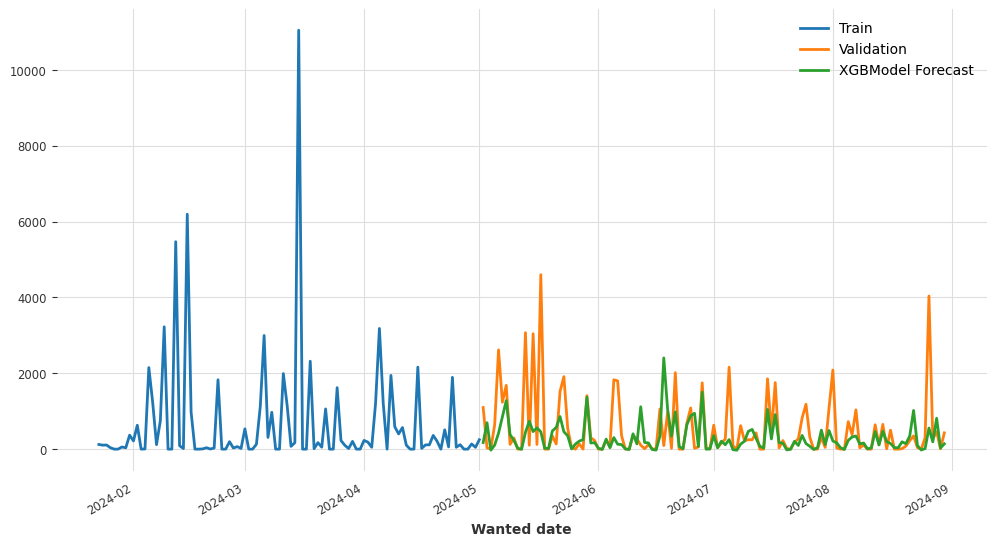

There is seasonality of order 5.
There is seasonality of order 7.
There is seasonality of order 19.
There is seasonality of order 21.


/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/299424543.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df["Product code description"] = cluster_df["Product code description"].astype("str")
/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/299424543.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_df = cluster_df[["Product code description", "Sales Qty"]].resample("D").sum().fillna(0)


Lags: 1, MAE: 60.14901272225971
Lags: 2, MAE: 63.200249473664385
Lags: 3, MAE: 76.54357358179833
Lags: 4, MAE: 28.151115585087744
Lags: 5, MAE: 54.78988733271922
Lags: 6, MAE: 40.523176936324965
Lags: 7, MAE: 34.03607560152357
Lags: 8, MAE: 35.28819531383963
Lags: 9, MAE: 41.13227173854589
Lags: 10, MAE: 43.97083555038803
Lags: 11, MAE: 42.6507716117319
Lags: 12, MAE: 29.98171339830584
Lags: 13, MAE: 104.35445729599235
Lags: 14, MAE: 58.609147419183216
Lags: 15, MAE: 113.42888250774588
Lags: 16, MAE: 107.24475192432561
Lags: 17, MAE: 60.20728332370766
Lags: 18, MAE: 56.838795896650346
Lags: 19, MAE: 194.57269203071752
Lags: 20, MAE: 139.7778145682436
Lags: 21, MAE: 186.1029735911976
Lags: 22, MAE: 242.5539626543187
Lags: 23, MAE: 266.0634560299314
Lags: 24, MAE: 420.0537892506142
Lags: 25, MAE: 296.6986734918819
Lags: 26, MAE: 178.01142047456474
Lags: 27, MAE: 26.42589321904931
Lags: 28, MAE: 246.960881334691
Lags: 29, MAE: 224.15471597717814
Lags: 30, MAE: 278.29635799817805
Best MAE:

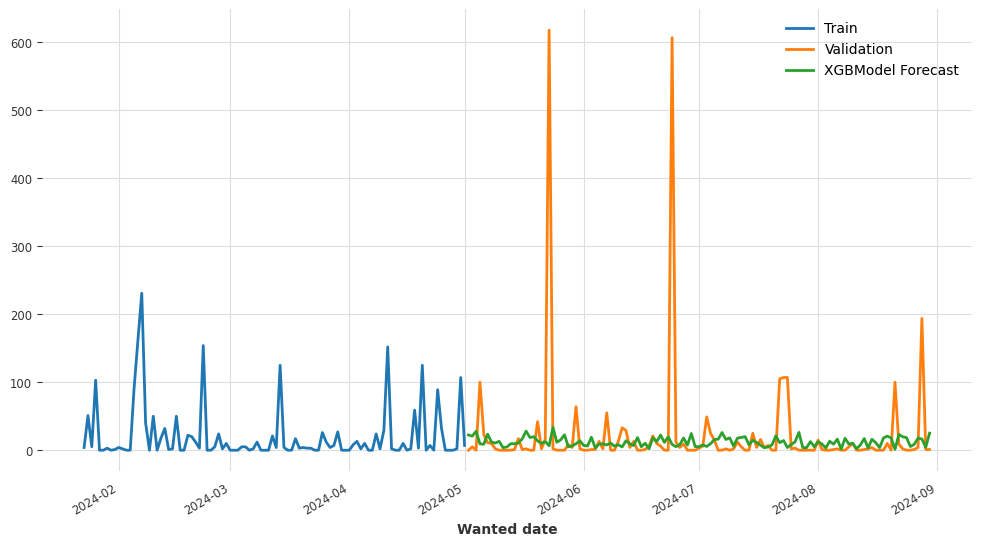

There is seasonality of order 4.
There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.


/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/299424543.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df["Product code description"] = cluster_df["Product code description"].astype("str")
/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/299424543.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_df = cluster_df[["Product code description", "Sales Qty"]].resample("D").sum().fillna(0)


Lags: 1, MAE: 938.8000884327022
Lags: 2, MAE: 955.4749348735021
Lags: 3, MAE: 958.7605801347859
Lags: 4, MAE: 888.7808769531856
Lags: 5, MAE: 1083.3221191071775
Lags: 6, MAE: 1018.7361064520011
Lags: 7, MAE: 1074.9242872585935
Lags: 8, MAE: 920.8057877564233
Lags: 9, MAE: 1199.8932966052994
Lags: 10, MAE: 1099.026382490623
Lags: 11, MAE: 1140.6160532797664
Lags: 12, MAE: 1146.999617796299
Lags: 13, MAE: 1001.6364082319677
Lags: 14, MAE: 1004.4754607490272
Lags: 15, MAE: 1118.8009265543014
Lags: 16, MAE: 1067.6489306629196
Lags: 17, MAE: 950.0125942975283
Lags: 18, MAE: 977.1433493046721
Lags: 19, MAE: 955.5992666194754
Lags: 20, MAE: 1058.2626738676354
Lags: 21, MAE: 830.3950941637158
Lags: 22, MAE: 1149.1893941415242
Lags: 23, MAE: 1061.360872119419
Lags: 24, MAE: 975.3568730664647
Lags: 25, MAE: 906.5662423096412
Lags: 26, MAE: 932.0798505064378
Lags: 27, MAE: 956.3461053228575
Lags: 28, MAE: 1104.5610775908162
Lags: 29, MAE: 1088.5660234561637
Lags: 30, MAE: 1175.938004383371
Best M

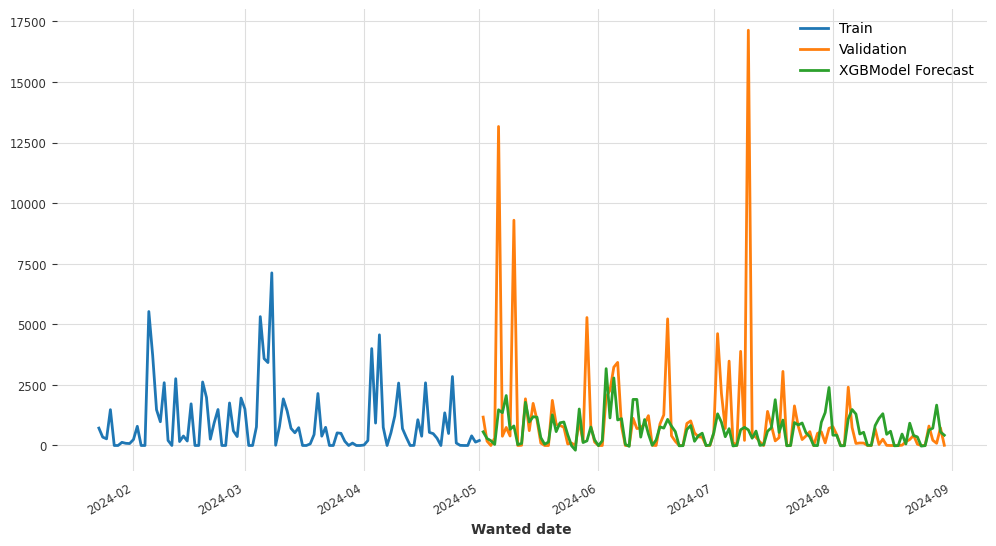

There is seasonality of order 2.
There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.


/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/299424543.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df["Product code description"] = cluster_df["Product code description"].astype("str")
/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/299424543.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_df = cluster_df[["Product code description", "Sales Qty"]].resample("D").sum().fillna(0)


Lags: 1, MAE: 674.3661058914563
Lags: 2, MAE: 537.5674782745109
Lags: 3, MAE: 508.85508260845154
Lags: 4, MAE: 583.7197769732514
Lags: 5, MAE: 507.7036889968825
Lags: 6, MAE: 501.126917171546
Lags: 7, MAE: 564.8266192349521
Lags: 8, MAE: 490.62154070257156
Lags: 9, MAE: 480.8418279068529
Lags: 10, MAE: 453.69700812529925
Lags: 11, MAE: 471.74214226746363
Lags: 12, MAE: 470.32740541233505
Lags: 13, MAE: 513.5238568231094
Lags: 14, MAE: 544.5588477465732
Lags: 15, MAE: 487.1150914661525
Lags: 16, MAE: 530.1615252114278
Lags: 17, MAE: 501.2890109264654
Lags: 18, MAE: 508.4682613345217
Lags: 19, MAE: 477.9348616150539
Lags: 20, MAE: 480.324685534293
Lags: 21, MAE: 473.93555087824006
Lags: 22, MAE: 474.7125017248895
Lags: 23, MAE: 485.10911227011485
Lags: 24, MAE: 470.7295418278245
Lags: 25, MAE: 489.83439629137024
Lags: 26, MAE: 465.84918677338885
Lags: 27, MAE: 473.62911076191045
Lags: 28, MAE: 467.0444451843904
Lags: 29, MAE: 461.23623416591283
Lags: 30, MAE: 486.9048795099101
Best MAE: 

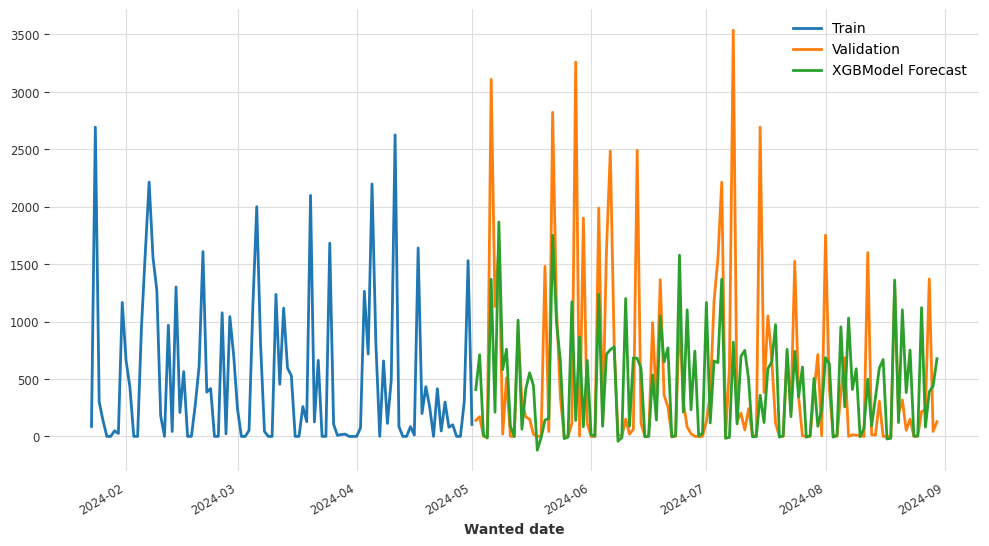

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 19.
There is seasonality of order 21.
There is seasonality of order 23.


/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/299424543.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df["Product code description"] = cluster_df["Product code description"].astype("str")
/var/folders/79/v_bpm6sx2v9bvsw1glz9r7c80000gn/T/ipykernel_36434/299424543.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_df = cluster_df[["Product code description", "Sales Qty"]].resample("D").sum().fillna(0)


Lags: 1, MAE: 419.6950533732402
Lags: 2, MAE: 424.0168226947469
Lags: 3, MAE: 481.0834823905929
Lags: 4, MAE: 449.4944091665843
Lags: 5, MAE: 434.9806348298453
Lags: 6, MAE: 378.8037289115023
Lags: 7, MAE: 383.52016603109263
Lags: 8, MAE: 402.4915997952469
Lags: 9, MAE: 415.4030858642799
Lags: 10, MAE: 346.53864869894073
Lags: 11, MAE: 336.89542160324817
Lags: 12, MAE: 318.53650749887316
Lags: 13, MAE: 334.42169566046107
Lags: 14, MAE: 331.16996400513926
Lags: 15, MAE: 338.2349545759234
Lags: 16, MAE: 328.2543376085246
Lags: 17, MAE: 336.66274256671755
Lags: 18, MAE: 345.05053451090805
Lags: 19, MAE: 346.2475945077652
Lags: 20, MAE: 305.6710887846868
Lags: 21, MAE: 302.9720270049966
Lags: 22, MAE: 327.23330826010584
Lags: 23, MAE: 308.4693968140882
Lags: 24, MAE: 327.326385159107
Lags: 25, MAE: 335.18323635094424
Lags: 26, MAE: 341.8459429636228
Lags: 27, MAE: 337.3002537653343
Lags: 28, MAE: 312.74425751057043
Lags: 29, MAE: 336.1811490450516
Lags: 30, MAE: 351.52245340379307
Best MAE

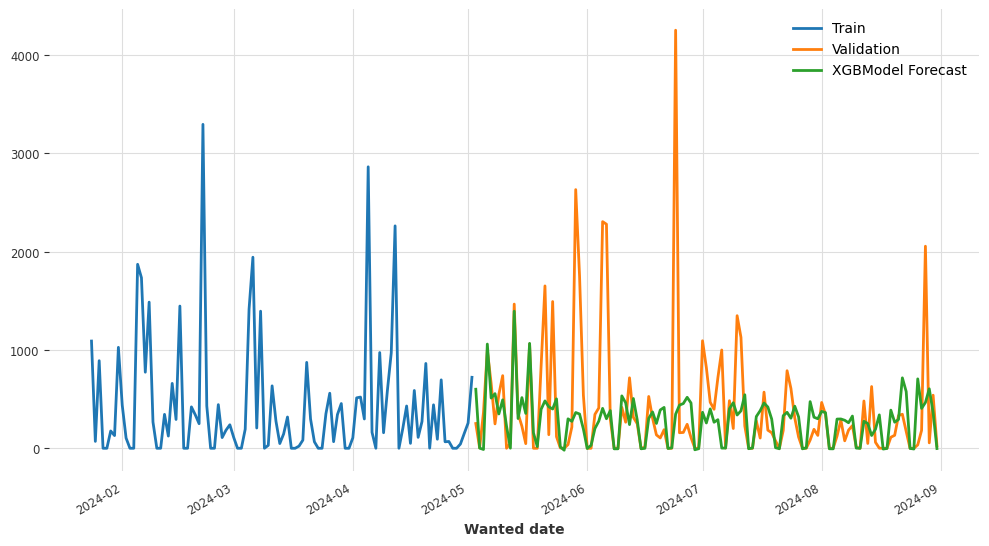

In [38]:
# Loop through top parts and run predictions
for cluster_df in clusters_list:
    cluster_df["Product code description"] = cluster_df["Product code description"].astype("str")
    resampled_df = cluster_df[["Product code description", "Sales Qty"]].resample("D").sum().fillna(0)
    predict(resampled_df)

## Results

After training two sets of models, we observed that both approaches provide solid predictions. In my assessment, the first approach (using categorical models) appears to be more effective. It performs particularly well for larger categories and offers easier interpretability. In contrast, the cluster-based models, while accurate, can be harder to interpret due to the complexity of clusters, which group multiple product codes without a clearly discernible logic.

From the experiments conducted, several suggestions for improvement emerged:
- **Enhanced Feature Engineering**: Developing additional features from the raw data could improve model performance.
- **Incorporate Future and Past Covariates**: Adding future covariates to the XGBoost model and using past sales data from other products, categories, or global sales figures as covariates could refine predictions.
- **Optimizing Clustering Approaches**: There is significant potential to enhance the logic behind cluster formation:
  - Introduce more features that capture detailed characteristics of each product code.
  - Experiment with different clustering methods to achieve more precise groupings.
- **Hyperparameter Tuning**: Applying hyperparameter tuning across both approaches may further improve the accuracy of predictions.

The current results demonstrate that recognizable patterns exist in sales volumes, which can be extracted and predicted with a high degree of accuracy. This indicates that further refinement in modeling and feature engineering can lead to even more reliable forecasts.